# Prediction of phase separation propensities of disordered proteins from sequence

Code to reproduce figures in <br> *von Bülow, S., Tesei, G., & Lindorff-Larsen, K. (2025). Prediction of phase separation propensities of disordered proteins from sequence. PNAS.*

The notebook requires the CALVADOS package, available here: https://github.com/KULL-Centre/CALVADOS

# Import and functions

In [ ]:
import calvados as cal
from calvados import sequence, build, analysis, slab_conc
from calvados.sequence import SeqFeatures

from predictor import *

import numpy as np
import pandas as pd
import numba as nb

import os
import MDAnalysis as mda
import matplotlib.pyplot as plt

from scipy.stats import linregress, sem, spearmanr
from scipy.spatial.distance import mahalanobis
from scipy.optimize import curve_fit

from itertools import combinations

from tqdm import tqdm
from joblib import dump, load
import yaml

import cProfile
import pstats

import warnings

import seaborn as sns

warnings.simplefilter("ignore")

cwd = os.getcwd()
cwd

In [2]:
plt.rcParams['font.size'] = 7
plt.rcParams['ytick.major.size'] = 2
plt.rcParams['ytick.minor.size'] = 1
plt.rcParams['xtick.major.size'] = 2
plt.rcParams['xtick.minor.size'] = 1
plt.rcParams['xtick.labelsize'] = 6
plt.rcParams['ytick.labelsize'] = 6
plt.rcParams['axes.linewidth'] = 0.5
plt.rcParams['axes.labelpad'] = 2
plt.rcParams['savefig.pad_inches'] = 0.1
plt.rcParams['figure.dpi'] = 300
plt.rcParams['lines.markersize'] = 3
plt.rcParams['lines.markeredgewidth'] = 0.5
plt.rcParams['lines.linewidth'] = 1.
plt.rcParams['font.serif'] = 'Times New Roman'
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['font.monospace'] = 'Courier New'

col1x = 3.425 # column
col2x = 7. # 2x column

In [3]:
residues = pd.read_csv('data/residues.csv').set_index('one')
# fcolor = plt.cm.summer
nu_file = 'models/svr_model_nu.joblib'

simulated = np.loadtxt('data/simulated.txt',dtype='int')

ah_intgrl_map = sequence.make_ah_intgrl_map(residues)
lambda_map = sequence.make_lambda_map(residues)

features = ['mean_lambda', 'faro', 'shd', 'ncpr', 'fcr', 'scd', 'ah_ij','nu_svr']
features_full = ['N','mean_lambda','faro', 'shd','fcr','ncpr','scd', 'mw','ah_ij','kappa','nu_svr']

In [4]:
features_clean = {
    'mean_lambda' : r'$\bar{\lambda}$',
    'faro' : r'$f_\mathrm{aro}$',
    'shd' : 'SHD',
    'ncpr' : 'NCPR',
    'fcr' : 'FCR',
    'scd' : 'SCD',
    'ah_ij' : r'AH$_\mathrm{pairs}$',
    'q_ij' : r'q$_\mathrm{pairs}$',
    'nu_svr' : r'$\nu_\mathrm{SVR}$',
    'N' : 'N',
    'kappa' : r'$\kappa$',
    'mw' : r'M$_w$',
    'dG' : '$\Delta G$ [$k_\mathrm{B}T$]',
    'width_interf' : 'Interface width [nm]',
    'rg_rel' : r'$\overline{R}_{g,\text{Interface}}$' + ' / ' +r'$\overline{R}_{g,\text{Dense}}$',
    'sz' : r'$S_z$ (Interface)',
    'seqid' : 'Seq. ID',
    'seqJS' : 'JS Div.',
}

targets_clean = {
    'dG' : r'$\Delta G$ [kT]',
    'logcdil_mgml' : r'ln(c$_\mathrm{dil}$ [g/L])',
    'log10cdil_mgml' : r'log$_{10}$(c$_\mathrm{dil}$ [g/L])',
    'dG_pred_error' : r'$\Delta G$ Error [kT]',
}

mltypes_clean = {
    'svr' : 'SVR',
    'mlp' : 'Dense NN',
}

units_clean = {
    'dG' : r'k$_B$T',
    'logcdil_mgml' : ''
}

# ora = plt.cm.viridis
# colors = [ora(0.4), ora(0.7), ora(1.)]
# alphas = [0.7, 0.6, 0.3]

colors = np.array([
    [1., 101., 165.],
    [220., 140., 46.], # [220., 175., 46.],
    [31., 107., 65.],
    [200., 80., 45.],
    [127., 0., 255.]
])
colors /= 255.

col1x = 3.425 # column
col2x = 7. # 2x column

In [5]:
limits = {
    'scd' : [-5,6],
    # 'scd' : [-8,6],
    'ncpr' : [-0.25, 0.25],
    'kappa' : [0.0, 0.8],
    'faro' : [0., 0.15],
    'nu' : [0.2, 0.7],
    'nu_svr' : [0.45, 0.62],
    'mw' : [0., 60000],
    'fcr' : [0., 0.6],
    'mean_lambda' : [0.3, 0.6],
    'shd' : [1.5, 6.],
    'N' : [0, 800],
    'ah_ij' : [-0.9,-0.3],
}

In [6]:
def calc_cden_mgml(N,mw,val):
    box = build.calc_box(N)
    nprot = build.calc_nprot_slab(N,box)

    cbulk = nprot / (box[0] * box[1] * box[2]) / 6.022e23 * 1e24 * 1e3 # mM, bulk
    
    if val['dG'] == 0.:
        cden = cbulk
    elif val['cden'] < cbulk:
        cden = cbulk
    else:
        cden = val['cden']

    cden_mgml = cden * mw  / 1e3
    return cden, cden_mgml

def convert_cden(df):
    for key, val in df.iterrows():
        seq = val['fasta']
        N = len(seq)
        # calc mw
        mw = sequence.calc_mw(seq)
        df.loc[key,'mw'] = mw
        # convert cdil
        cden, cden_mgml = calc_cden_mgml(N,mw,val)
        df.loc[key,'cden'] = cden
        df.loc[key,'cden_mgml'] = cden_mgml
    return df

# Load all dataframes

In [7]:
df_full = pd.read_csv('data/IDRome_DB_full.csv').set_index('id')

# Training data
df_merged = pd.read_csv('data/df_training.csv').set_index('seq_name')

# Skip simulations with two condensed phases
skiplist = ['Q5HYW3_413_569','P51861_1_262','Q9NYF8_1_593',
            'P98179_78_157','Q13936_420_515','Q1KMD3_636_747',
           'O60841_1_608','Q9NQX4_794_1370','Q9ULD5_260_638',
           'Q86VX9_1_247','Q14011_79_172',
            'P09651_187_372'] # Skip hnRNPA1 (exp. validation)

# Validation IDRome90
valid_intra_skiplist = ['P78332_1_467']
df_valid_intra = pd.read_csv('data/df_validation_IDRome90.csv').set_index('seq_name')
df_merged_with_intra = pd.concat([df_merged, df_valid_intra])

# Validation IDRome10
# df10 = pd.read_csv('IDRome_DB_10_features.csv').set_index('id')
valid_10_skiplist = ['Q9Y2H5_158_530','P38159_87_391']
df_valid_10 = pd.read_csv('data/df_validation_IDRome10.csv').set_index('seq_name')

# Validation exp. data
df_prots_ORE = pd.read_csv('data/df_prots_ORE.csv').set_index('name')

skiplist_all = skiplist[:-1] + valid_intra_skiplist + valid_10_skiplist # Don't plot A1 here (only removed to avoid leaking into validation data

In [8]:
# Range of input concentrations (For gray shading in all scatter plots:

input_concs = []

for name, val in df_merged_with_intra.iterrows():
    seq = str(val['fasta'])
    N = len(seq)
    box = cal.build.calc_box(N)
    nprot = calc_nprot_slab(N,box)
    Mw = cal.sequence.calc_mw(seq)
    c = cal.build.n_to_conc(nprot,box[0]*box[1]*box[2],Mw)
    input_concs.append(c) # g / L
input_concs = np.array(input_concs)

# Load ML Model

In [9]:
sim_sets = ['training', 'idrome90']
targets = ['dG','logcdil_mgml']#,'log10cdil_mgml','logcdil_mgml_norm']
mltypes = ['svr','mlp']

ncrossval = 50
C = 10
epsilon = 1e-2
alpha = 5
layers = (10,10)#(5,5)

models = {}
for sim_set in sim_sets:
    models[sim_set] = {}
    for mltype in mltypes:
        models[sim_set][mltype] = {}
        for target in targets:
            folder = f'models/{sim_set}/{mltype}/{target}'
            models[sim_set][mltype][target] = load(f'{folder}/model.joblib')

# Test model features and architecture

## Fig. S2: Test feature combinations

In [10]:
# df_merged_with_intra

In [11]:
target = 'dG'

df_temp = df_merged_with_intra.copy()
df_temp = add_features(df_temp,features_full,residues=residues,nu_file=nu_file)
df_temp = df_temp[features_full + [target]].dropna()

maxfeatures = 2
print(f'maxfeatures: {maxfeatures}')

ncrossval = 50

mltype = 'mlp'
C = 10.
epsilon = 1e-2

alpha = 5
layers = (10,10)

vertical_bar = []
ct = 0
vertical_bar.append(0)

labels = []

rps = []
rp_stds = []
rmsds = []
rmsd_stds = []

rmax = 0.

for ncomp in range(1, maxfeatures+1):# len(featurestr)+1):
    for feats in combinations(features_full,ncomp):
        label = [features_clean[f] for f in feats]#feats
        labels.append(label)

        X, y, X_keys = makeXy(df_temp, feats, target=target)
        model = Model(
            mltype = mltype,
            C = C,
            epsilon = epsilon,
            ncrossval = ncrossval,
            alpha = alpha,
            layers = layers
        )
        model.train(X,y,X_keys,verbose=False)
        rp_std = np.std([cval.rp for cval in model.crossvals])
        rmsd_std = np.std([cval.rmsd for cval in model.crossvals])
        if model.rp_mean > rmax:
            print(f'>>>>>> {label}   P:{model.rp_mean:.4f}   S:{model.rs_mean:.4f}  RMSD:{model.rmsd_mean:.3f}')
            rmax = model.rp_mean
        rmsd_stds.append(rmsd_std)
        rmsds.append(model.rmsd_mean)
        rp_stds.append(rp_std)
        rps.append(model.rp_mean)


00%|█████████████████████████████████████████| 389/389 [00:24<00:00, 16.15it/s]

maxfeatures: 2
>>>>>> ['N']   P:0.1799   S:0.1930  RMSD:3.098
>>>>>> ['$\\bar{\\lambda}$']   P:0.4813   S:0.3523  RMSD:2.771
>>>>>> ['$f_\\mathrm{aro}$']   P:0.4907   S:0.4940  RMSD:2.770
>>>>>> ['NCPR']   P:0.5690   S:0.5310  RMSD:2.577
>>>>>> ['N', '$f_\\mathrm{aro}$']   P:0.6234   S:0.6121  RMSD:2.485
>>>>>> ['$\\bar{\\lambda}$', 'NCPR']   P:0.6702   S:0.6354  RMSD:2.337
>>>>>> ['$\\bar{\\lambda}$', '$\\nu_\\mathrm{SVR}$']   P:0.7569   S:0.7384  RMSD:2.029
>>>>>> ['$f_\\mathrm{aro}$', '$\\nu_\\mathrm{SVR}$']   P:0.7623   S:0.7625  RMSD:2.046
>>>>>> ['AH$_\\mathrm{pairs}$', '$\\nu_\\mathrm{SVR}$']   P:0.7715   S:0.7663  RMSD:1.995


In [12]:
# Results for final model (to compare)
model = models['idrome90']['mlp']['dG']
rp_full = model.rp_mean
rmsd_full = model.rmsd_mean
rmsd_std_full = np.std([cval.rmsd for cval in model.crossvals])
rp_std_full = np.std([cval.rp for cval in model.crossvals])

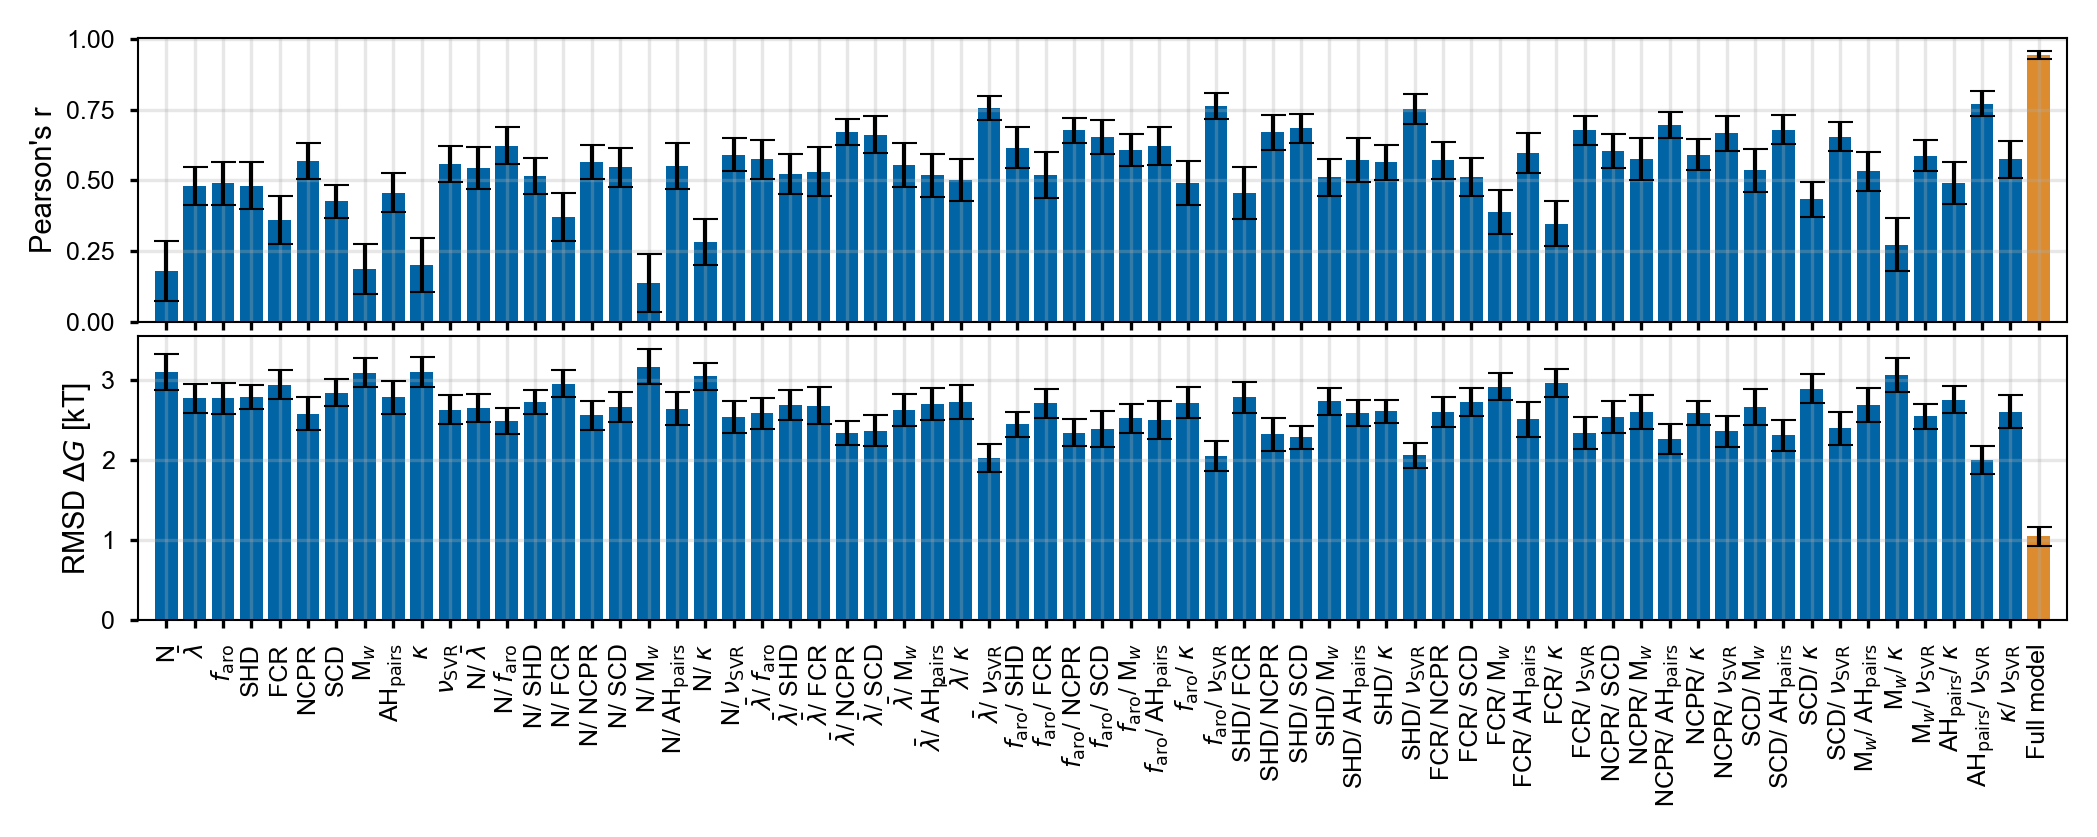

In [15]:
fig, ax = plt.subplots(2,1,figsize=(col2x,4/10*col2x),sharex=True)
xs = np.arange(len(labels)+1)
ax[0].bar(xs[:-1], rps, color=colors[0])
ax[0].errorbar(xs[:-1],rps,yerr=rp_stds,color='black',capsize=3,ls='none')
ax[0].bar(xs[-1], model.rp_mean, color=colors[1])
ax[0].errorbar(xs[-1],model.rp_mean,yerr=rp_std_full,color='black',capsize=3,ls='none')
ax[1].bar(xs[:-1], rmsds, color=colors[0])
ax[1].errorbar(xs[:-1],rmsds,yerr=rmsd_stds,color='black',capsize=3,ls='none')
ax[1].bar(xs[-1], model.rmsd_mean, color=colors[1])
ax[1].errorbar(xs[-1],model.rmsd_mean,yerr=rmsd_std_full,color='black',capsize=3,ls='none')

for idx in range(2):
    ax[idx].grid(alpha=0.3)

ax[1].set_xticks(xs)
labels_full = labels + [['Full model']]
ax[1].set_xticklabels(["/ ".join(l) for l in labels_full], rotation=90, fontsize=6)
ax[1].set(xlim=(xs[0]-1,xs[-1]+1))
ax[0].set(ylabel="Pearson's r")
ax[1].set(ylabel=f'RMSD {targets_clean["dG"]}')
fig.tight_layout(h_pad=0)

## Fig. S3: Scan network architectures

In [16]:
ncrossval = 20 # 100

mltype = 'mlp'
alphas = [1,5,10,20]
layers_selection = [
    (1),
    (5),
    (10),
    (20),
    (1,1),
    (5,5),
    (10,10),
    (20,20)
]

rmax = 0.

print(features)
hyperparam_search = {}

for target in ['dG','logcdil_mgml']:
    df_temp = df_merged_with_intra[features + [target]].dropna()
    X, y, X_keys = makeXy(df_temp, features, target=target)
    
    rmsds = []
    rmsd_stds = []
    labels = []
    
    for layers in layers_selection:
        print('=============')
        print(f'layers: {layers}')
        print('--------------')
        for alpha in alphas:
            print(f'alpha: {alpha}')
            model = Model(
                mltype = mltype,
                alpha = alpha,
                layers = layers,
                ncrossval = ncrossval
            )
            model.train(X,y,X_keys,verbose=False)
            rmsd_std = np.std([cval.rmsd for cval in model.crossvals])
            if model.rp_mean > rmax:
                print(f'>>> P:{model.rp_mean:.3f}   S:{model.rs_mean:.3f}  RMSD:{model.rmsd_mean:.2f}')
                rmax = model.rp_mean
            else:
                print(f'P:{model.rp_mean:.3f}   S:{model.rs_mean:.3f}  RMSD:{model.rmsd_mean:.2f}')
            rmsds.append(model.rmsd_mean)
            rmsd_stds.append(rmsd_std)
            labels.append(r'$\alpha =$'+f'{alpha}'+r',  hl$=$'+f'{layers}')

    hyperparam_search[target] = {
        'labels' : labels,
        'rmsds' : rmsds,
        'rmsd_stds' : rmsd_stds
    }

['mean_lambda', 'faro', 'shd', 'ncpr', 'fcr', 'scd', 'ah_ij', 'nu_svr']
layers: 1
--------------
alpha: 1
>>> P:0.860   S:0.825  RMSD:1.57
alpha: 5
>>> P:0.870   S:0.837  RMSD:1.59
alpha: 10
P:0.865   S:0.836  RMSD:1.58
alpha: 20
P:0.863   S:0.835  RMSD:1.62
layers: 5
--------------
alpha: 1
>>> P:0.912   S:0.890  RMSD:1.29
alpha: 5
P:0.910   S:0.884  RMSD:1.27
alpha: 10
P:0.904   S:0.874  RMSD:1.37
alpha: 20
P:0.884   S:0.865  RMSD:1.54
layers: 10
--------------
alpha: 1
>>> P:0.925   S:0.900  RMSD:1.20
alpha: 5
>>> P:0.929   S:0.899  RMSD:1.18
alpha: 10
P:0.917   S:0.889  RMSD:1.25
alpha: 20
P:0.896   S:0.872  RMSD:1.42
layers: 20
--------------
alpha: 1
>>> P:0.935   S:0.912  RMSD:1.12
alpha: 5
P:0.928   S:0.898  RMSD:1.13
alpha: 10
P:0.910   S:0.882  RMSD:1.32
alpha: 20
P:0.891   S:0.883  RMSD:1.43
layers: (1, 1)
--------------
alpha: 1
P:0.861   S:0.824  RMSD:1.59
alpha: 5
P:0.846   S:0.816  RMSD:1.65
alpha: 10
P:0.857   S:0.822  RMSD:1.64
alpha: 20
P:0.871   S:0.840  RMSD:1.57
la

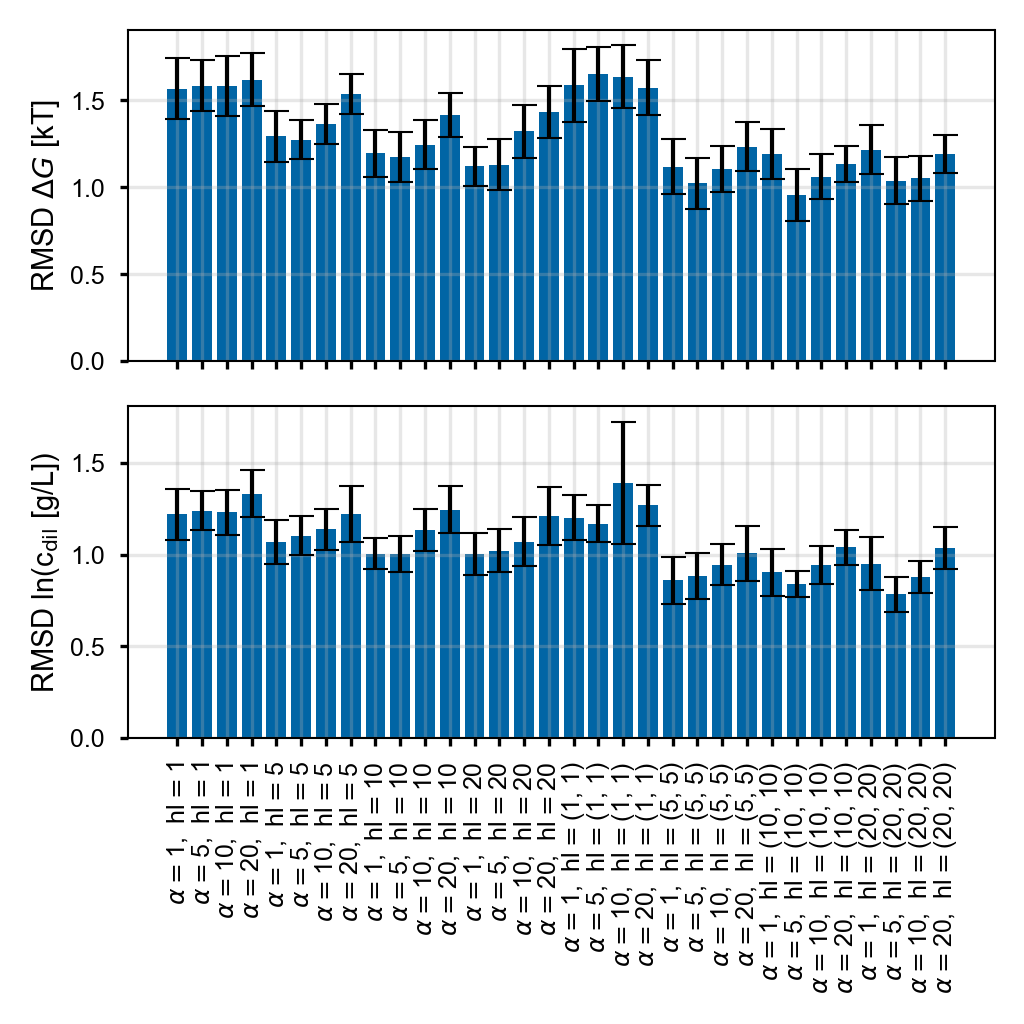

In [17]:
fig, ax = plt.subplots(2,1,figsize=(col1x,col1x),sharex=True)

for idx, (tar, val) in enumerate(hyperparam_search.items()):
    axij = ax[idx]
    xs = np.arange(len(val['rmsds']))
    axij.bar(xs,val['rmsds'],color=colors[0])
    axij.errorbar(xs,val['rmsds'],yerr=val['rmsd_stds'],color='black',capsize=3,ls='none')
    axij.set_xticks(xs)
    axij.set_xticklabels(val['labels'],rotation=90)
    axij.set(ylabel=f'RMSD {targets_clean[tar]}')
    axij.grid(alpha=0.3)
fig.tight_layout()

# Fig. 2: Scatter plots

In [18]:
ranges = {
    'sim' : {
        'dG' : (-10.5, 0.4),
        'logcdil_mgml' : (-4.2,4.9)
    },
    'svr' : {
        'dG' : (-11, 4),
        'logcdil_mgml' : (-5,7)
    },
    'mlp' : {
        'dG' : (-11, 1),
        'logcdil_mgml' : (-5,5.2)
    }
}

In [19]:
scatters_crossval = {}

for sim_set in sim_sets:
    scatters_crossval[sim_set] = {}
    for mltype in mltypes:
        scatters_crossval[sim_set][mltype] = {}
        for target in targets:
            # maxy = 0
            scatters_crossval[sim_set][mltype][target] = {}
            scatters_crossval[sim_set][mltype][target]['ysim'] = []
            scatters_crossval[sim_set][mltype][target]['ypred'] = []
            scatterdict_sim = {}
            scatterdict_pred = {}

            model = models[sim_set][mltype][target]
            
            for idx, crosv in enumerate(model.crossvals):
                for name, ysim, ypred in zip(crosv.X_test_keys, crosv.y_test, crosv.ypred_test):
                    if name not in scatterdict_pred:
                        scatterdict_pred[name] = []
                    scatterdict_sim[name] = ysim
                    scatterdict_pred[name].append(ypred)

            for name, ysim in scatterdict_sim.items():
                scatters_crossval[sim_set][mltype][target]['ysim'].append(ysim)
                scatters_crossval[sim_set][mltype][target]['ypred'].append(np.mean(scatterdict_pred[name]))
                if sim_set == 'idrome90' and mltype == 'mlp' and target == 'dG':
                    df_merged_with_intra.loc[name,'dG_pred'] = np.mean(scatterdict_pred[name])
            scatters_crossval[sim_set][mltype][target]['pearson'] = model.rp_mean
            scatters_crossval[sim_set][mltype][target]['rmsd'] = model.rmsd_mean

In [20]:
scatters_validation90 = {}
scatters_validation10 = {}

In [21]:
sim_set = 'training'
# target = 'logcdil_mgml' #'dG'
mltype = 'mlp'

for target in ['dG','logcdil_mgml']:
    model = models[sim_set][mltype][target]
    
    X, y, X_keys = makeXy(df_valid_intra, features, target=target)
    
    ypred = model.predict(X)
    ypred_m = np.mean(ypred,axis=0)
    
    scatters_validation90[target] = {}
    scatters_validation90[target]['ysim'] = y
    scatters_validation90[target]['ypred'] = ypred_m
    
    rp, rs, rmsd = model.calc_statistics(y,ypred_m)
    scatters_validation90[target]['pearson'] = rp
    scatters_validation90[target]['rmsd'] = rmsd

Pearson: 0.926, Spearman: 0.915, RMSD: 1.051
Pearson: 0.917, Spearman: 0.923, RMSD: 0.911


In [22]:
sim_set = 'idrome90'
# target = 'dG'#'logcdil_mgml'
mltype = 'mlp'

for target in ['dG','logcdil_mgml']:
    model = models[sim_set][mltype][target]
    X, y, X_keys = makeXy(df_valid_10, features, target=target)
    ypred = model.predict(X)
    ypred_m = np.mean(ypred,axis=0)

    scatters_validation10[target] = {}
    scatters_validation10[target]['ysim'] = y
    scatters_validation10[target]['ypred'] = ypred_m
    
    rp, rs, rmsd = model.calc_statistics(y,ypred_m)

    scatters_validation10[target]['pearson'] = rp
    scatters_validation10[target]['rmsd'] = rmsd

    if target == 'dG':
        df_valid_10.loc[X_keys,'dGpred'] = ypred_m

Pearson: 0.941, Spearman: 0.945, RMSD: 0.898
Pearson: 0.930, Spearman: 0.949, RMSD: 0.815


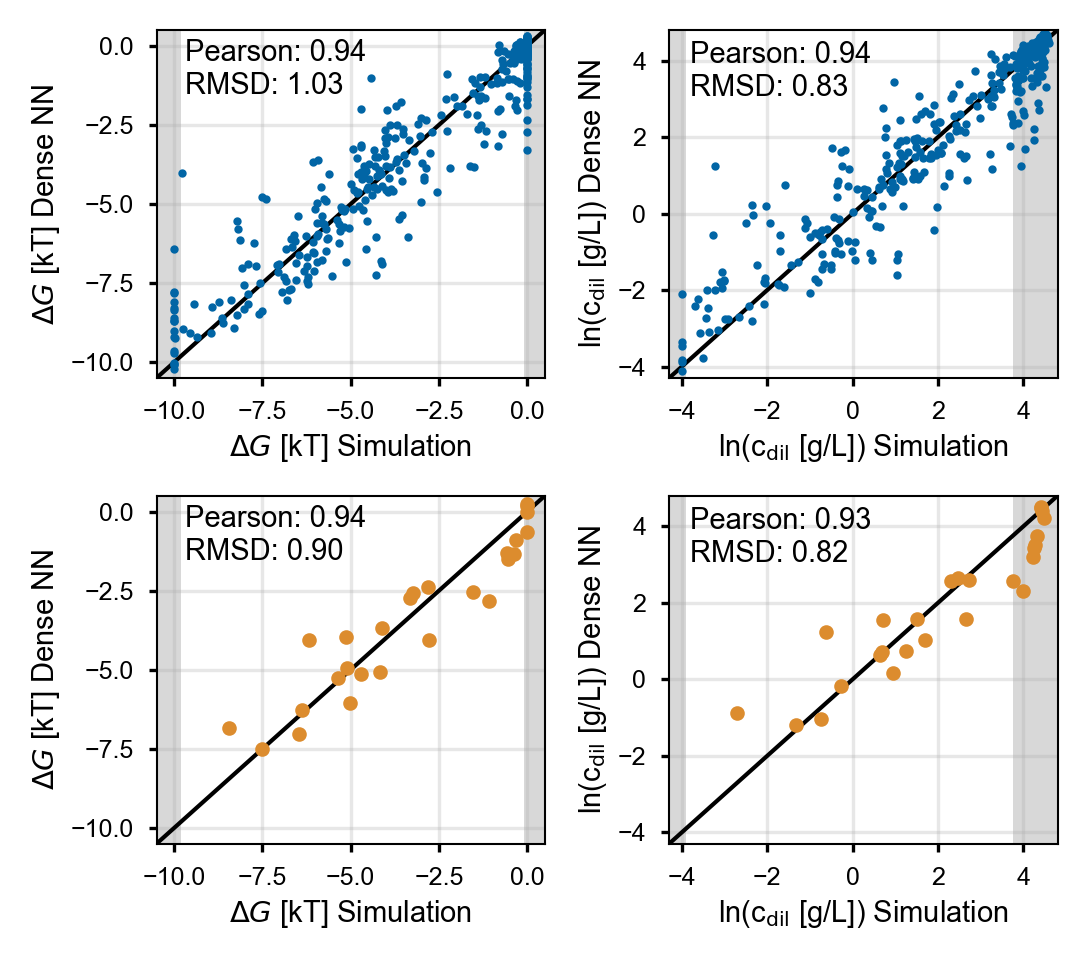

In [23]:
fig, ax = plt.subplots(2,2,figsize=(3.425,3))

# titles = ['A','B','C','D']

# Cross-validations

for idx, target in enumerate(['dG','logcdil_mgml']):
    if target == 'dG':
        xs = np.arange(-11,1.1,0.1)
        xlim = (-10.5,0.5)
        ylim = (-10.5,0.5)
        # yticks = np.arange(-10,0.1,2)
        xticks = np.arange(-10,0.1,2.5)
        yticks = np.arange(-10,0.1,2.5)
        text_offset = 0.8
        vspan_lower = (-10.5,-9.8)
        vspan_upper = (-0.1,1)

    elif target == 'logcdil_mgml':
        xs = np.arange(-5,5.5,0.1)
        xlim = (-4.3,4.8)
        ylim = (-4.3,4.8)
        xticks = np.arange(-4,5.1,2)
        yticks = np.arange(-4,5.1,2)
        text_offset = 0.5
        vspan_lower = (-4.3,-3.9)
        vspan_upper = (min(np.log(input_concs)),5)

    for jdx, scatters in enumerate([scatters_crossval, scatters_validation10]):
        if scatters == scatters_crossval:
            ysim = scatters['idrome90']['mlp'][target]['ysim']
            ypred = scatters['idrome90']['mlp'][target]['ypred']
            rp = scatters['idrome90']['mlp'][target]['pearson']
            rmsd = scatters['idrome90']['mlp'][target]['rmsd']
            marker = '.'
        else:
            ysim = scatters[target]['ysim']
            ypred = scatters[target]['ypred']
            rp = scatters[target]['pearson']
            rmsd = scatters[target]['rmsd']
            marker = 'o'

        axij = ax[jdx,idx]#ax[idx+2*jdx]#,0]
        axij.plot(xs,xs,color='black')
        axij.plot(ysim,ypred,marker,color=colors[jdx])#fcolor(0))

        axij.axvspan(vspan_lower[0],vspan_lower[1],color='gray',alpha=0.3,linewidth=0)
        axij.axvspan(vspan_upper[0],vspan_upper[1],color='gray',alpha=0.3,linewidth=0)
        # axij.set_title('Cross-validation')
        axij.text(xlim[0]+text_offset,ylim[1]-0.3,
                f'Pearson: {rp:.2f} \nRMSD: {rmsd:.2f}',
               verticalalignment='top',
                 fontsize=7)
        
        axij.set(xlabel=f'{targets_clean[target]} Simulation',
                    ylabel=f'{targets_clean[target]} Dense NN')
        axij.set(xlim=xlim,ylim=ylim)
        axij.set_xticks(yticks)
        axij.set_yticks(yticks)

fig.tight_layout(pad=0,w_pad=1.08,h_pad=1.08)#
# fig.savefig('figures_revision/fig2_new.pdf')

# Fig. S11: Error model

In [24]:
scatterdict_dG_sim = {}
scatterdict_dG_pred = {}

modeldG = models['idrome90']['mlp']['dG']
for idx, crosv in enumerate(modeldG.crossvals):
    for name, ysim, ypred in zip(crosv.X_test_keys, crosv.y_test, crosv.ypred_test):
        if name not in scatterdict_dG_pred:
            scatterdict_dG_pred[name] = []
        scatterdict_dG_sim[name] = ysim
        scatterdict_dG_pred[name].append(ypred)

for name, val in scatterdict_dG_pred.items():
    df_merged_with_intra.loc[name,'dG_xval'] = np.mean(val)
    df_merged_with_intra.loc[name,'dG_pred_error'] = np.abs(np.mean(val) - scatterdict_dG_sim[name])

In [25]:
features_tmp = features + ['dG_xval']

print(f'features: {features_tmp}')

target = 'dG_pred_error'#'logcdil_mgml'#'dG'
target_clean = target

print(f'target: {target}')

print(target)
df_temp = df_merged_with_intra[features_tmp + [target]].dropna()
print(len(df_temp))

ncrossval = 50

X, y, X_keys = makeXy(df_temp, features_tmp, target=target)

mltype = 'svr' # 'svr'
C = 10 # 10
epsilon = 1e-2

alpha = 1e-1 # 5
layers = (5,5)  # (10,10)

model = Model(
    mltype = mltype,
    C = C,
    epsilon = epsilon,
    layers = layers,
    alpha = alpha,
    ncrossval = ncrossval
)
print(model.layers, model.alpha)
model.train(X,y,X_keys,verbose=False)

print(f'P:{model.rp_mean:.3f}   S:{model.rs_mean:.3f}  RMSD:{model.rmsd_mean:.2f}')

scatterdict_sim = {}
scatterdict_pred = {}

for idx, crosv in enumerate(model.crossvals):
    for name, ysim, ypred in zip(crosv.X_test_keys, crosv.y_test, crosv.ypred_test):
        if name not in scatterdict_pred:
            scatterdict_pred[name] = []
        scatterdict_sim[name] = ysim
        scatterdict_pred[name].append(ypred)
        # ax.text(np.min(crosv.y_train),ranges[mltype][target][1]-0.5,#np.max(crosv.ypred_train),
        #         f'Pearson r: {model.rp_mean:.2f} \nRMSD: {model.rmsd_mean:.2f}',
        #        verticalalignment='top')

for name, ysim in scatterdict_sim.items():
    df_merged_with_intra.loc[name,'dG_pred_error_pred'] = np.mean(scatterdict_pred[name])

print(np.sqrt(np.mean(df_merged_with_intra['dG_pred_error']**2)))
print(np.sqrt(np.mean(df_merged_with_intra['dG_pred_error_pred']**2)))

features: ['mean_lambda', 'faro', 'shd', 'ncpr', 'fcr', 'scd', 'ah_ij', 'nu_svr', 'dG_xval']
target: dG_pred_error
dG_pred_error
389
(5, 5) 0.1
P:0.546   S:0.575  RMSD:0.63
0.9895731377984321
0.7035435999581119


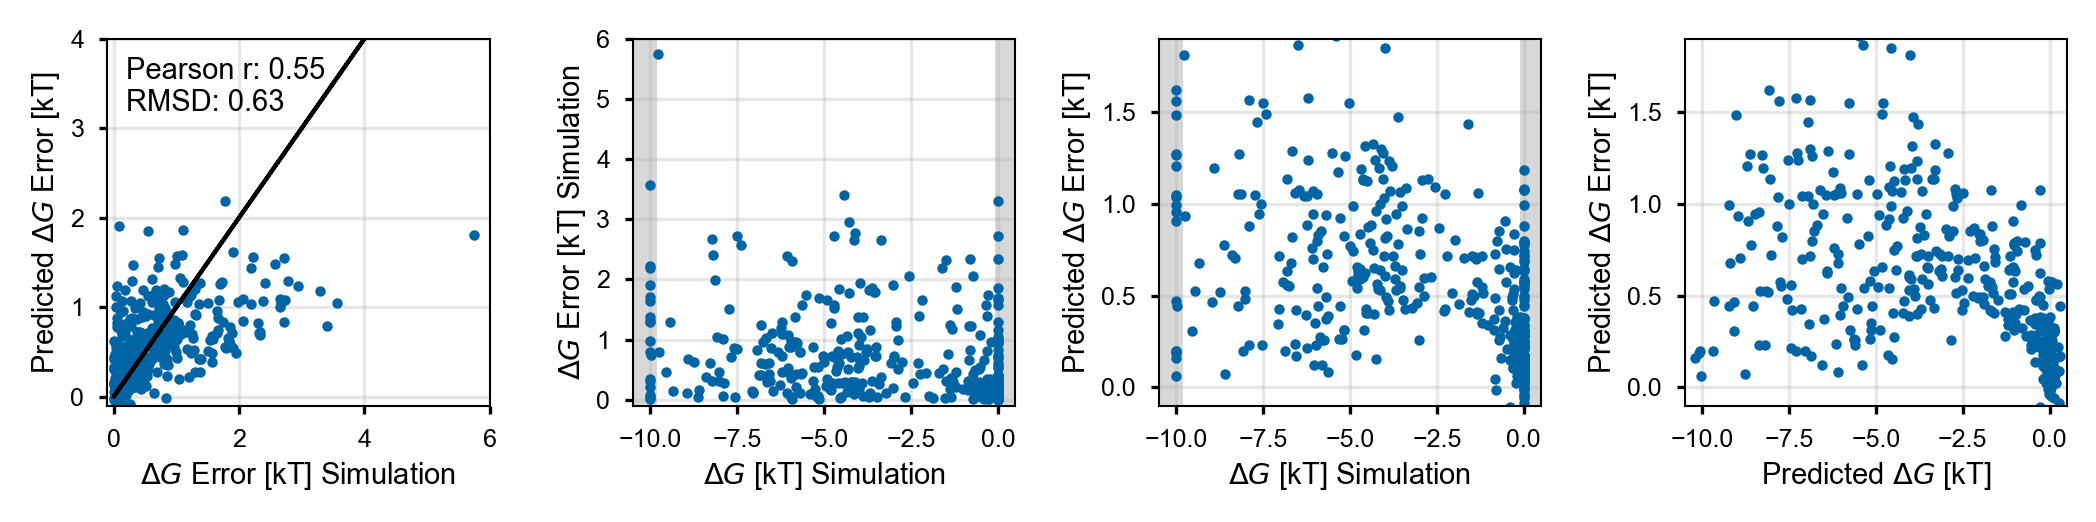

In [26]:
fig, ax = plt.subplots(1,4,figsize=(col2x,2/8*col2x))


vspan_lower = (-10.5,-9.8)
vspan_upper = (-0.1,1)
for idx in range(1,3):
    ax[idx].axvspan(vspan_lower[0],vspan_lower[1],color='gray',alpha=0.3,linewidth=0)
    ax[idx].axvspan(vspan_upper[0],vspan_upper[1],color='gray',alpha=0.3,linewidth=0)

ax[0].plot(df_merged_with_intra['dG_pred_error'],df_merged_with_intra['dG_pred_error_pred'],'.',color=colors[0],markersize=4)
ax[0].plot(np.min(scatterdict_sim).values(),np.max(scatterdict_sim).values(),color='black',lw=1.)
# ax[0].set_title('Cross-validation',fontsize=10)#mltypes_clean[mltype])
ax[1].plot(df_merged_with_intra['dG'],df_merged_with_intra['dG_pred_error'],'.',color=colors[0],markersize=4)
ax[2].plot(df_merged_with_intra['dG'],df_merged_with_intra['dG_pred_error_pred'],'.',color=colors[0],markersize=4)
ax[3].plot(df_merged_with_intra['dG_xval'],df_merged_with_intra['dG_pred_error_pred'],'.',color=colors[0],markersize=4)

# ax.plot(xs,xs,color='black')#,ls='dashed')
ax[0].set(xlabel=f'{targets_clean[target]} Simulation', ylabel=f'Predicted {targets_clean[target]}')
ax[1].set(xlabel=f'{targets_clean["dG"]} Simulation', ylabel=f'{targets_clean[target]} Simulation')
ax[2].set(xlabel=f'{targets_clean["dG"]} Simulation', ylabel=f'Predicted {targets_clean[target]}')
ax[3].set(xlabel=f'Predicted {targets_clean["dG"]}', ylabel=f'Predicted {targets_clean[target]}')

ax[0].text(0.2,3.8,#np.max(crosv.ypred_train),
        f'Pearson r: {model.rp_mean:.2f}\nRMSD: {model.rmsd_mean:.2f}',
       verticalalignment='top')#,horizontalalignment='right')

ax[0].set(xlim=(-0.1,6),ylim=(-0.1,4))
ax[1].set(xlim = (-10.5,0.5))
ax[2].set(xlim = (-10.5,0.5))
ax[3].set(xlim = (-10.5,0.5))

ax[1].set(ylim=(-0.1,6))
ax[2].set(ylim=(-0.1,1.9))
ax[3].set(ylim=(-0.1,1.9))

fig.tight_layout()
# fig.savefig(f'figures_revision/figS_scatter_crossval_dG_pred_error.pdf')

# Compare with exp. data

In [27]:
def calc_mgml(cdil, seq, cap=-4): # cdil in molar
    mw = cal.sequence.calc_mw(seq)
    cdil_mgml = cdil * mw
    if cdil_mgml < np.exp(cap): # like in calc_cdil_mgml of predictor.py
        cdil_mgml = np.exp(cap)
    logcdil_mgml = np.log(cdil_mgml)
    return cdil_mgml, logcdil_mgml

df_csat_exp = pd.read_csv('data_revision/df_csat_exp_fixed.csv',index_col='name')

### New Exp. data
seq6_exp = { # uM
    'A9Z0R7' : 270.01287, # 'EWSR'
    'Q5JVS0' : 113.62792, # 'Intracellular HylBP' 
    'Q8N1D0' : 51.08225, # 'Beck-Weid'
    'O43823' : 38.32026, # 'Akinase'
    'Q9Y2W1' : 12.33154, # 'THRAP_THSD7A'
    'Q9NS56' : 1.66419, # 'E3 Ub lig'
}
seq6_name_mapping = {
    'A9Z0R7' : 'EWSR',
    'Q5JVS0' : 'Intracellular HylBP',
    'Q8N1D0' : 'Beck-Weid',
    'O43823' : 'Akinase',
    'Q9Y2W1' : 'THRAP_THSD7A',
    'Q9NS56' : 'E3 Ub lig',
}

wts_all = {
    'wts' : ['A1','LAF1','Ddx4n1','FUS','A9Z0R7','Q5JVS0','Q8N1D0','O43823',
       'Q9Y2W1','Q9NS56'],
}

variants_all = {
    'A1variants' : ['M20GP20S','A1','M14NP14Q','M23SP23T','P23GM23SP7FM7Y',
              'A1allF','A1allW','A1allY','A1FtoW','A1YtoW','A1Wminus',
              'P7FM7Y','M3RP3K','A1S150','P23GM23S','P23GM23SM12FP12Y',
              'M10GP10S','M12FP12Y','M30GP30S',
                   'V1','V2','V3','V4','V5'],
    'LAF1variants' : ['LAF1','LAF1D2130','LAF1shuf'],
}

variants_all = {
    'A1variants' : ['M20GP20S','A1','M14NP14Q','M23SP23T','P23GM23SP7FM7Y',
              'A1allF','A1allW','A1allY','A1FtoW','A1YtoW','A1Wminus',
              'P7FM7Y','M3RP3K','A1S150','P23GM23S','P23GM23SM12FP12Y',
              'M10GP10S','M12FP12Y','M30GP30S',
                   'V1','V2','V3','V4','V5'],
    'A1variants_noTrp' : ['M20GP20S','A1','M14NP14Q','M23SP23T','P23GM23SP7FM7Y',
              'A1allF','A1allY',
              'P7FM7Y','M3RP3K','A1S150','P23GM23S','P23GM23SM12FP12Y',
              'M10GP10S','M12FP12Y','M30GP30S',
                   'V1','V2','V3','V4','V5'],
    'A1variants_Trp' : ['A1allW','A1FtoW','A1YtoW','A1Wminus'],
    'LAF1variants' : ['LAF1','LAF1D2130','LAF1shuf'],
}

In [28]:
for idx, (wtname, wtlist) in enumerate(wts_all.items()):
    print(wtname)
    rp, rs, rmsd = model.calc_statistics(df_csat_exp.loc[wtlist,'logcdil_mgml_exp'], 
                                         df_csat_exp.loc[wtlist,'logcdil_mgml_pred'])
         
for idx, (varname, varlist) in enumerate(variants_all.items()):
    print(varname)
    rp, rs, rmsd = model.calc_statistics(df_csat_exp.loc[varlist,'logcdil_mgml_exp'], 
                                     df_csat_exp.loc[varlist,'logcdil_mgml_pred'])

wts
Pearson: 0.588, Spearman: 0.067, RMSD: 1.122
A1variants
Pearson: 0.759, Spearman: 0.782, RMSD: 1.367
A1variants_noTrp
Pearson: 0.936, Spearman: 0.948, RMSD: 0.542
A1variants_Trp
Pearson: 0.962, Spearman: 0.949, RMSD: 3.121
LAF1variants
Pearson: 0.945, Spearman: 1.000, RMSD: 0.556


In [29]:
## Scan Trp Lambdas
csats_exp = df_csat_exp['logcdil_mgml_exp'].values
# seqs = list(df_csat_exp['fasta'].values)

size = 1
xi = 2 # 5

model = models['idrome90']['mlp']['logcdil_mgml']

trp_lambdas = np.arange(0.9,1.8,0.01)

rmsds_scan = []
csats_pred_all = []
residues_all = []

for idx, l in enumerate(trp_lambdas):
    residues_trial = residues.copy()
    residues_trial.loc['W','lambdas'] = l

    if not np.all(residues_trial.lambdas>0):
        raise
    ys = np.zeros((len(df_csat_exp.index)))
    for seq_idx, (name, val) in enumerate(df_csat_exp.iterrows()):
        seq = val['fasta']
        flexhis = val['flexhis']
        pH = val['pH']
        # print(name,flexhis,pH)
        X = X_from_seq(seq,features,residues=residues_trial,charge_termini=True,nu_file=nu_file,
                      flexhis=flexhis,pH=pH)
        ys[seq_idx] = np.mean(model.predict(X))

    rp, rs, rmsd = model.calc_statistics(ys,csats_exp)
    
    print(f'{idx}, {l:.2f}, RMSD: {rmsd:.3f}')
    rmsds_scan.append(rmsd)
    csats_pred_all.append(ys)
    residues_all.append(residues_trial)

Pearson: 0.583, Spearman: 0.595, RMSD: 1.481
0, 0.90, RMSD: 1.481
Pearson: 0.596, Spearman: 0.620, RMSD: 1.459
1, 0.91, RMSD: 1.459
Pearson: 0.609, Spearman: 0.620, RMSD: 1.436
2, 0.92, RMSD: 1.436
Pearson: 0.621, Spearman: 0.628, RMSD: 1.414
3, 0.93, RMSD: 1.414
Pearson: 0.634, Spearman: 0.648, RMSD: 1.392
4, 0.94, RMSD: 1.392
Pearson: 0.646, Spearman: 0.659, RMSD: 1.369
5, 0.95, RMSD: 1.369
Pearson: 0.658, Spearman: 0.659, RMSD: 1.347
6, 0.96, RMSD: 1.347
Pearson: 0.670, Spearman: 0.673, RMSD: 1.325
7, 0.97, RMSD: 1.325
Pearson: 0.681, Spearman: 0.676, RMSD: 1.304
8, 0.98, RMSD: 1.304
Pearson: 0.693, Spearman: 0.682, RMSD: 1.282
9, 0.99, RMSD: 1.282
Pearson: 0.703, Spearman: 0.683, RMSD: 1.261
10, 1.00, RMSD: 1.261
Pearson: 0.714, Spearman: 0.697, RMSD: 1.240
11, 1.01, RMSD: 1.240
Pearson: 0.724, Spearman: 0.711, RMSD: 1.219
12, 1.02, RMSD: 1.219
Pearson: 0.734, Spearman: 0.711, RMSD: 1.198
13, 1.03, RMSD: 1.198
Pearson: 0.744, Spearman: 0.711, RMSD: 1.177
14, 1.04, RMSD: 1.177
Pears

In [30]:
model = models['idrome90']['mlp']['logcdil_mgml']

csats_pred_orig = np.zeros((len(df_csat_exp)))
for seq_idx, (name, val) in enumerate(df_csat_exp.iterrows()):
    seq = val['fasta']
    flexhis = val['flexhis']
    pH = val['pH']
    X = X_from_seq(seq,features,residues=residues,charge_termini=True,nu_file=nu_file)
    csats_pred_orig[seq_idx] = np.mean(model.predict(X))
rp, rs, rmsd_orig = model.calc_statistics(csats_exp,csats_pred_orig)

Pearson: 0.692, Spearman: 0.682, RMSD: 1.283


In [31]:
wts_all = {
    'Literature' : ['A1','LAF1','Ddx4n1','FUS'], # 'A1/LAF1/Ddx4/FUS'
    'This study' : ['A9Z0R7','Q5JVS0','Q8N1D0','O43823',
       'Q9Y2W1','Q9NS56'],
}

variants_all = {
    'A1' : ['M20GP20S','A1','M14NP14Q','M23SP23T','P23GM23SP7FM7Y',
              'A1allF','A1allW','A1allY','A1FtoW','A1YtoW','A1Wminus',
              'P7FM7Y','M3RP3K','A1S150','P23GM23S','P23GM23SM12FP12Y',
              'M10GP10S','M12FP12Y','M30GP30S',
                   'V1','V2','V3','V4','V5'],
    'LAF1' : ['LAF1','LAF1D2130','LAF1shuf'],
    # 'V1-V5' : ['V1','V2','V3','V4','V5'],
}

## Fig. 3: Pred. vs. exp.

Literature
Pearson: 0.442, Spearman: 0.400, RMSD: 0.423
This study
Pearson: 0.593, Spearman: 0.257, RMSD: 1.406
A1
Pearson: 0.759, Spearman: 0.782, RMSD: 1.367
LAF1
Pearson: 0.945, Spearman: 1.000, RMSD: 0.556


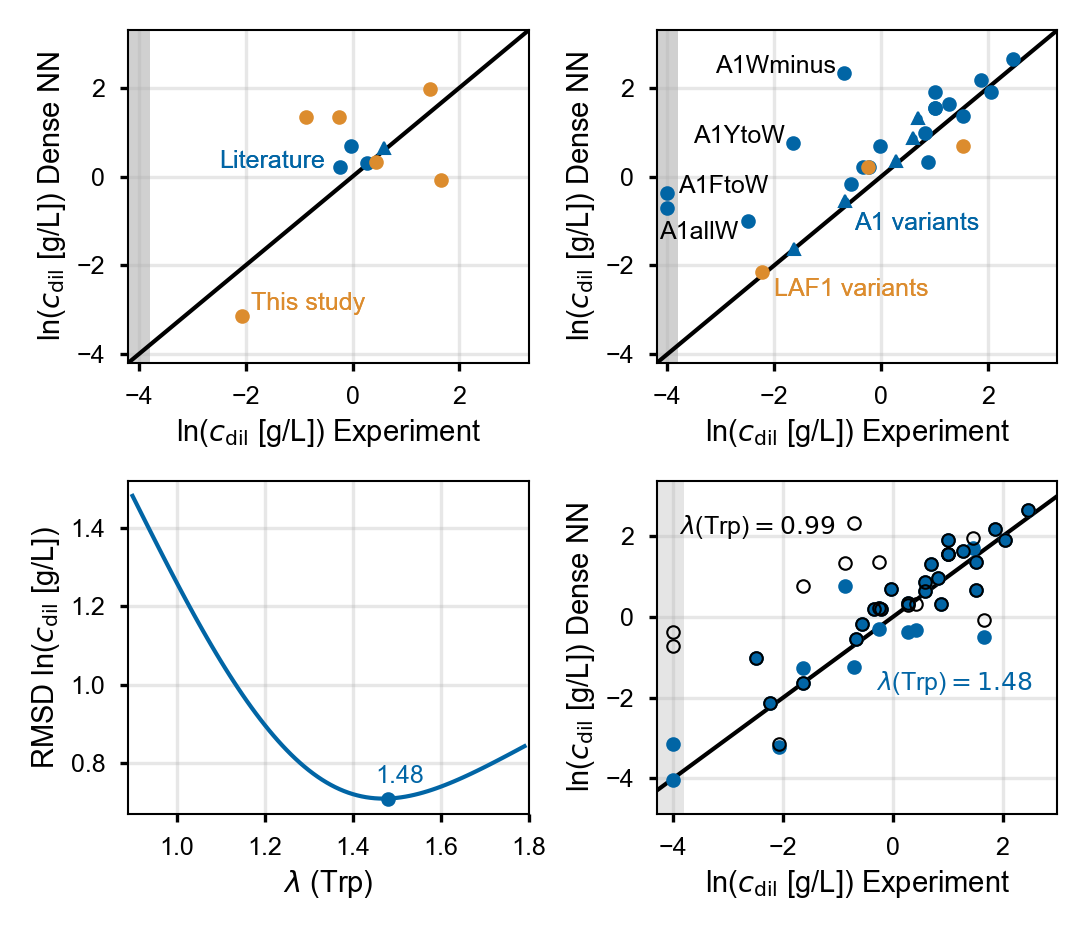

In [32]:
fig, ax = plt.subplots(2,2,figsize=(3.425,2.9))

for idx in range(2):
    xs = np.arange(-5,5,0.1)
    ax[0,idx].plot(xs,xs,color='black')
    ax[0,idx].set(xlabel='ln($c_\mathrm{dil}$ [g/L]) Experiment', ylabel=r'ln($c_\mathrm{dil}$ [g/L]) Dense NN')
    ax[0,idx].set(xlim=(-4.2,3.3),ylim=(-4.2,3.3))

vspan_limits = (-4.3,-3.8)

# Plot 1
for idx, (wtname, wtlist) in enumerate(wts_all.items()):
    axij = ax[0,0]
    print(wtname)
    rp, rs, rmsd = model.calc_statistics(df_csat_exp.loc[wtlist,'logcdil_mgml_exp'], 
                                         df_csat_exp.loc[wtlist,'logcdil_mgml_pred'])
    # color = f'C{idx}'
    axij.axvspan(vspan_limits[0],vspan_limits[1],color='gray',alpha=0.2,linewidth=0)
    # axij.plot(df_csat_exp.loc[wtlist,'logcdil_mgml_exp'], df_csat_exp.loc[wtlist,'logcdil_mgml_pred'],
                # '.',color=colors[idx],label=wtname)
    for wt in wtlist:
        temp = df_csat_exp.loc[wt,'temp']
        ionic = df_csat_exp.loc[wt,'ionic']
        if (temp == 293):# and (ionic == 0.15):
            markerstyle = 'o'
        elif temp != 293:
            markerstyle = '^'
        # else:
        #     markerstyle = 'v'
        exp = df_csat_exp.loc[wt,'logcdil_mgml_exp']
        pred = df_csat_exp.loc[wt,'logcdil_mgml_pred']
        axij.plot(exp, pred,
                'o',color=colors[idx],marker=markerstyle)
    axij.text(-2.5,0.2,'Literature',color=colors[0],fontsize=6)
    axij.text(-1.9,-3,'This study',color=colors[1],fontsize=6)
        # if np.abs(pred-exp) > 2:
            # ax[0].text(exp-0.2, pred, wt, fontsize=8, horizontalalignment='right')

# Plot 2
special_labels = ['A1allW','A1FtoW','A1YtoW','A1Wminus']

for idx, (varname, varlist) in enumerate(variants_all.items()):
    axij = ax[0,1]
    print(varname)
    rp, rs, rmsd = model.calc_statistics(df_csat_exp.loc[varlist,'logcdil_mgml_exp'], 
                                     df_csat_exp.loc[varlist,'logcdil_mgml_pred'])
    # color = f'C{idx}'
    axij.axvspan(vspan_limits[0],vspan_limits[1],color='gray',alpha=0.2,linewidth=0)
    axij.plot(df_csat_exp.loc[varlist,'logcdil_mgml_exp'], df_csat_exp.loc[varlist,'logcdil_mgml_pred'],
        '.',color=colors[idx],label=varname)
    for var in varlist:
        temp = df_csat_exp.loc[var,'temp']
        ionic = df_csat_exp.loc[var,'ionic']
        if (temp == 293): #and (ionic == 0.15):
            markerstyle = 'o'
        elif temp != 293:
            markerstyle = '^'
        # else:
        #     markerstyle = 'v'
        exp = df_csat_exp.loc[var,'logcdil_mgml_exp']
        pred = df_csat_exp.loc[var,'logcdil_mgml_pred']
        axij.plot(exp, pred,
                'o',color=colors[idx],marker=markerstyle)
        # if np.abs(pred-exp) > 2:
        if var in special_labels:
            xoffset = 0.2
            yoffset = 0
            ha = 'left'
            if var == 'A1allW':
                xoffset = -0.15
                yoffset = -0.7
            if var in ['A1Wminus','A1YtoW']:
                xoffset = -0.15
                ha = 'right'

            axij.text(exp+xoffset, pred+yoffset, var, fontsize=6, horizontalalignment=ha)
    axij.text(-0.5,-1.2,'A1 variants',color=colors[0], fontsize=6)
    axij.text(-2,-2.7,'LAF1 variants',color=colors[1], fontsize=6)
    # ax[0,idx].legend(fontsize=12,loc=4)

# ax[0].set_title('Wild types')
# ax[1].set_title('Variants')

# Plot 3
axij = ax[1,0]
axij.plot(trp_lambdas, rmsds_scan,c=colors[0])
axij.grid(alpha=0.3)
axij.set(xlabel='$\lambda$ (Trp)', ylabel='RMSD ln($c_\mathrm{dil}$ [g/L])')
# ax[2].set_title('Tryptophan ad-hoc optimisation')
axij.plot(trp_lambdas[58],rmsds_scan[58],'o',color=colors[0])
axij.text(trp_lambdas[58]-0.03,rmsds_scan[58]+0.04,f'{trp_lambdas[58]:.2f}',c=colors[0],fontsize=6)
axij.set(xlim=(trp_lambdas[0]-0.01,trp_lambdas[-1]+0.01))

# Plot 4
axij = ax[1,1]
xs = np.arange(-4.5,3.1,0.1)
axij.axvspan(vspan_limits[0],vspan_limits[1],color='gray',alpha=0.2,linewidth=0)
axij.plot(xs,xs,color='black',lw=1)
axij.plot(csats_exp,csats_pred_all[58],'o',c=colors[0],
           label=f'$\lambda$:{residues_all[58].lambdas["W"]:.2f}, RMSD:{rmsds_scan[58]:.2f}',
          )
axij.plot(csats_exp,csats_pred_orig,'o',c='black',
           label=f'$\lambda$:{residues.lambdas["W"]:.2f}, RMSD:{rmsd_orig:.2f}',
          fillstyle='none')

axij.set(xlabel='ln($c_\mathrm{dil}$ [g/L]) Experiment',ylabel='ln($c_\mathrm{dil}$ [g/L]) Dense NN')
axij.set(xlim=(-4.3,3.0))
# ax[3].set_title('Predictions orig. vs. optimized $\lambda$(Trp)')
# axij.legend(fontsize=12)
axij.text(-0.3,-1.8,r'$\lambda$(Trp)$=1.48$',color=colors[0],fontsize=6)
# axij.text(-3.7,2.1,r'$\lambda$(W)$=0.99$',color='black')
axij.text(-3.9,2.05,r'$\lambda$(Trp)$=0.99$',color='black',fontsize=6)

fig.tight_layout(pad=0,w_pad=1.08,h_pad=1.08)#h_pad=0.04167, w_pad=0.04167)
# fig.savefig('figures_revision/fig3_new.pdf')

## Fig. S4: Pred. new data vs sim.

Pearson: 0.877, Spearman: 0.700, RMSD: 1.308
Pearson: 0.748, Spearman: 0.300, RMSD: 1.185
Pearson: 0.936, Spearman: 0.700, RMSD: 0.988


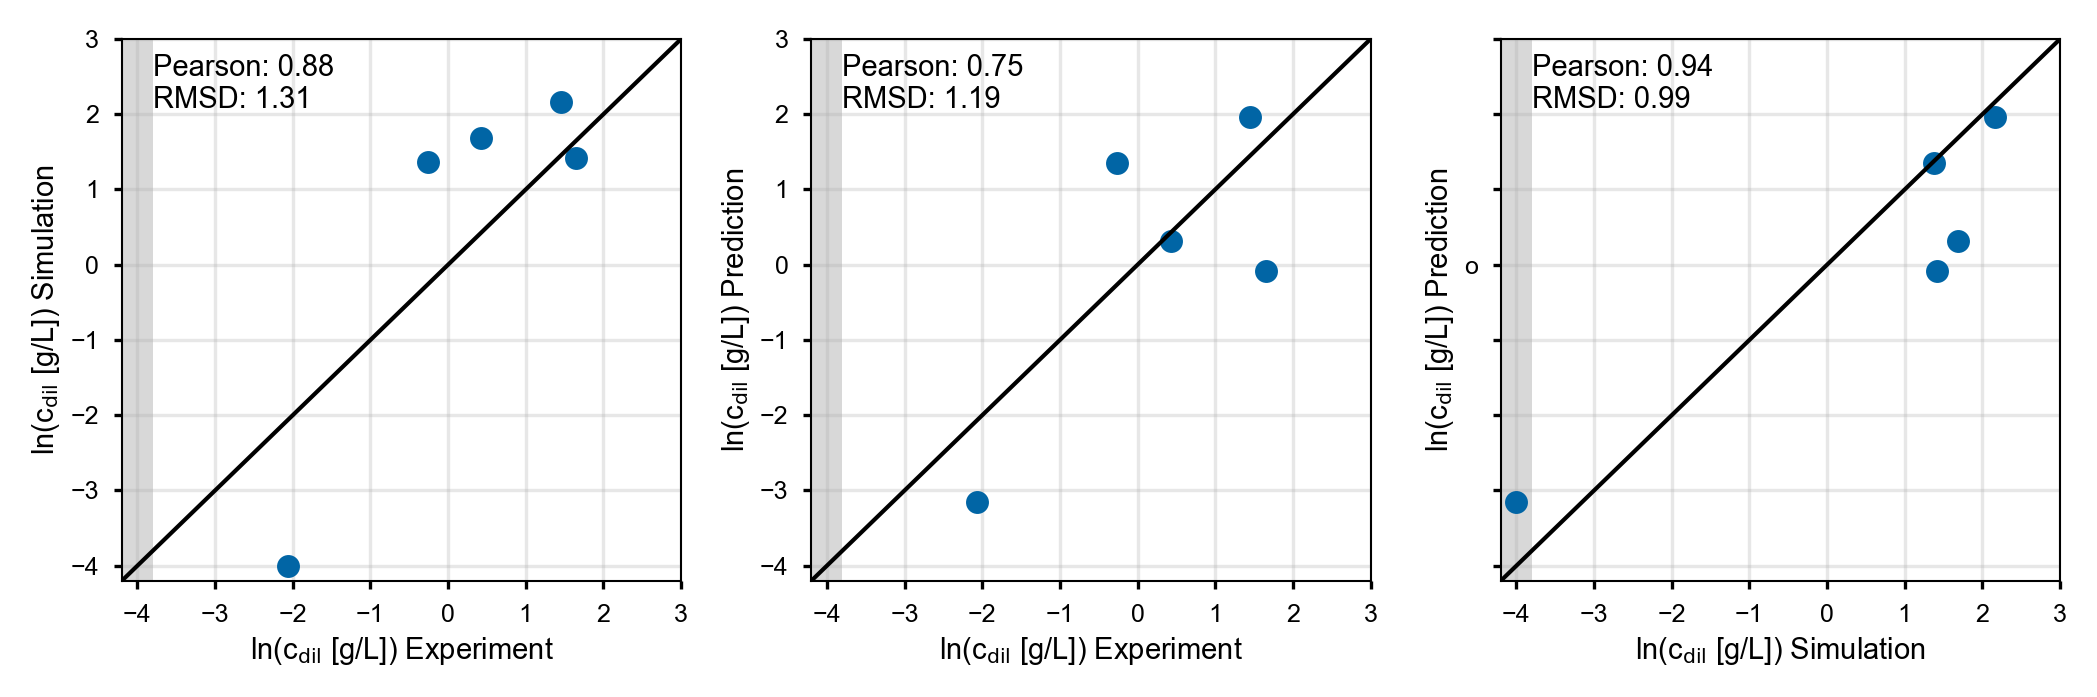

In [90]:
seq6_list = list(seq6_exp.keys())
seq5_list = seq6_list[:]
seq5_list.remove('Q9Y2W1')

fig, ax = plt.subplots(1,3,figsize=(col2x,col2x/3))

rp, rs, rmsd = model.calc_statistics(df_csat_exp.loc[seq5_list,'logcdil_mgml_exp'], df_csat_exp.loc[seq5_list,'logcdil_mgml_sim'])

ax[0].plot(df_csat_exp.loc[seq5_list,'logcdil_mgml_exp'], df_csat_exp.loc[seq5_list,'logcdil_mgml_sim'],'o',
        color=colors[0],markersize=5)
ax[0].text(-3.8,2.8,f'Pearson: {rp:.2f} \nRMSD: {rmsd:.2f}',
       verticalalignment='top',
         fontsize=7)

rp, rs, rmsd = model.calc_statistics(df_csat_exp.loc[seq5_list,'logcdil_mgml_exp'], df_csat_exp.loc[seq5_list,'logcdil_mgml_pred'])

ax[1].plot(df_csat_exp.loc[seq5_list,'logcdil_mgml_exp'], df_csat_exp.loc[seq5_list,'logcdil_mgml_pred'],'o',
        color=colors[0],markersize=5)
ax[1].text(-3.8,2.8,f'Pearson: {rp:.2f} \nRMSD: {rmsd:.2f}',
       verticalalignment='top',
         fontsize=7)

rp, rs, rmsd = model.calc_statistics(df_csat_exp.loc[seq5_list,'logcdil_mgml_sim'], df_csat_exp.loc[seq5_list,'logcdil_mgml_pred'])

ax[2].plot(df_csat_exp.loc[seq5_list, 'logcdil_mgml_sim'], df_csat_exp.loc[seq5_list, 'logcdil_mgml_pred'],'o',
        'o',c=colors[0],label='C2 simulation',markersize=5)
ax[2].text(-3.8,2.8,f'Pearson: {rp:.2f} \nRMSD: {rmsd:.2f}',
       verticalalignment='top',
         fontsize=7)

for idx in range(3):
    xs = np.arange(-5,5.1)
    ax[idx].plot(xs,xs,c='black')

    ax[idx].set(xlim=(-4.2,3.),ylim=(-4.2,3.))
    ax[idx].set_xticks(np.arange(-4,3.1))
    ax[idx].set_yticks(np.arange(-4,3.1))
    ax[idx].axvspan(-4.2,-3.8,color='gray',alpha=0.3,linewidth=0)

ax[0].set(xlabel=f'{targets_clean["logcdil_mgml"]} Experiment',
                    ylabel=f'{targets_clean["logcdil_mgml"]} Simulation')

ax[1].set(xlabel=f'{targets_clean["logcdil_mgml"]} Experiment',
                    ylabel=f'{targets_clean["logcdil_mgml"]} Prediction')

ax[2].set(xlabel=f'{targets_clean["logcdil_mgml"]} Simulation',
                    ylabel=f'{targets_clean["logcdil_mgml"]} Prediction')

# ax.legend(fontsize=6,loc=4)
fig.tight_layout()
# fig.savefig('figures_revision/figS_expnew_sim_pred.pdf')

# Fig. S5: Fraction of Trp

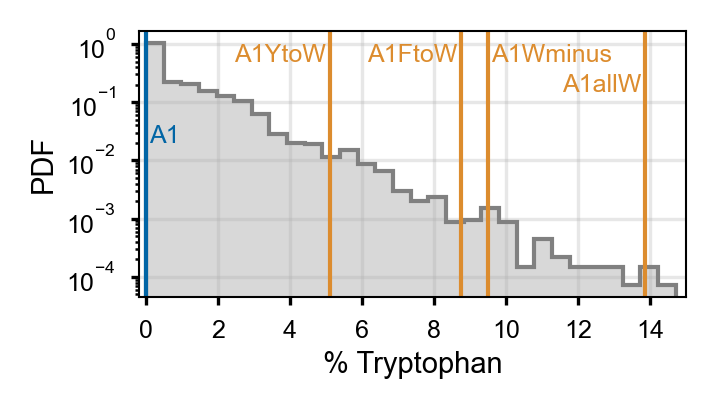

In [80]:
import re
# get fraction of W

for name, val in df_full.iterrows():
    fracW = len(re.findall('W',val['fasta'])) / len(val['fasta'])
    df_full.loc[name,'fracW'] = fracW * 100 # in percent

import re
for name, val in df_csat_exp.iterrows():
    fracW = len(re.findall('W',val['fasta'])) / len(val['fasta'])
    df_csat_exp.loc[name,'fracW'] = fracW * 100 # in percent

# fracW_A1 = df_csat_exp.loc['A1','fasta']

special_labels = ['A1allW','A1FtoW','A1YtoW','A1Wminus']

fig, ax = plt.subplots(figsize=(col1x*0.7,col1x*0.4))
ax.hist(df_full['fracW'],bins=30,color='gray',density=True,alpha=0.3)
ax.hist(df_full['fracW'],bins=30,histtype='step',color='gray',density=True)

for s in special_labels:
    y = 0.5
    if s in ['A1YtoW', 'A1FtoW', 'A1allW']:
        ha = 'right'
        offset = -0.1
    else:
        ha = 'left'
        offset = 0.1
    if s == 'A1allW':
        y = 1.5e-1
    ax.text(df_csat_exp.loc[s,'fracW']+offset,y,s,fontsize=6,color=colors[1],horizontalalignment=ha)
    ax.axvline(df_csat_exp.loc[s,'fracW'],color=colors[1])
    
ax.text(df_csat_exp.loc['A1','fracW']+0.1,2e-2,'A1',fontsize=6,color=colors[0],horizontalalignment='left')
ax.axvline(df_csat_exp.loc['A1','fracW'],color=colors[0])

ax.set(xlim=(-0.2,15))
ax.set_xticks(np.arange(0,15,2))

ax.set_yscale('log')
ax.set(xlabel='% Tryptophan',ylabel='PDF')
fig.tight_layout()
# fig.savefig('figures_revision/figS_percent_trp.pdf')

# Fig. S6: C2 vs. C3 predictions

19
18
Pearson: 0.924, Spearman: 0.928, RMSD: 0.467
Pearson: 0.902, Spearman: 0.901, RMSD: 0.691
Pearson: 0.763, Spearman: 0.812, RMSD: 1.157
Pearson: 0.949, Spearman: 0.950, RMSD: 0.589
Pearson: 0.901, Spearman: 0.928, RMSD: 0.844


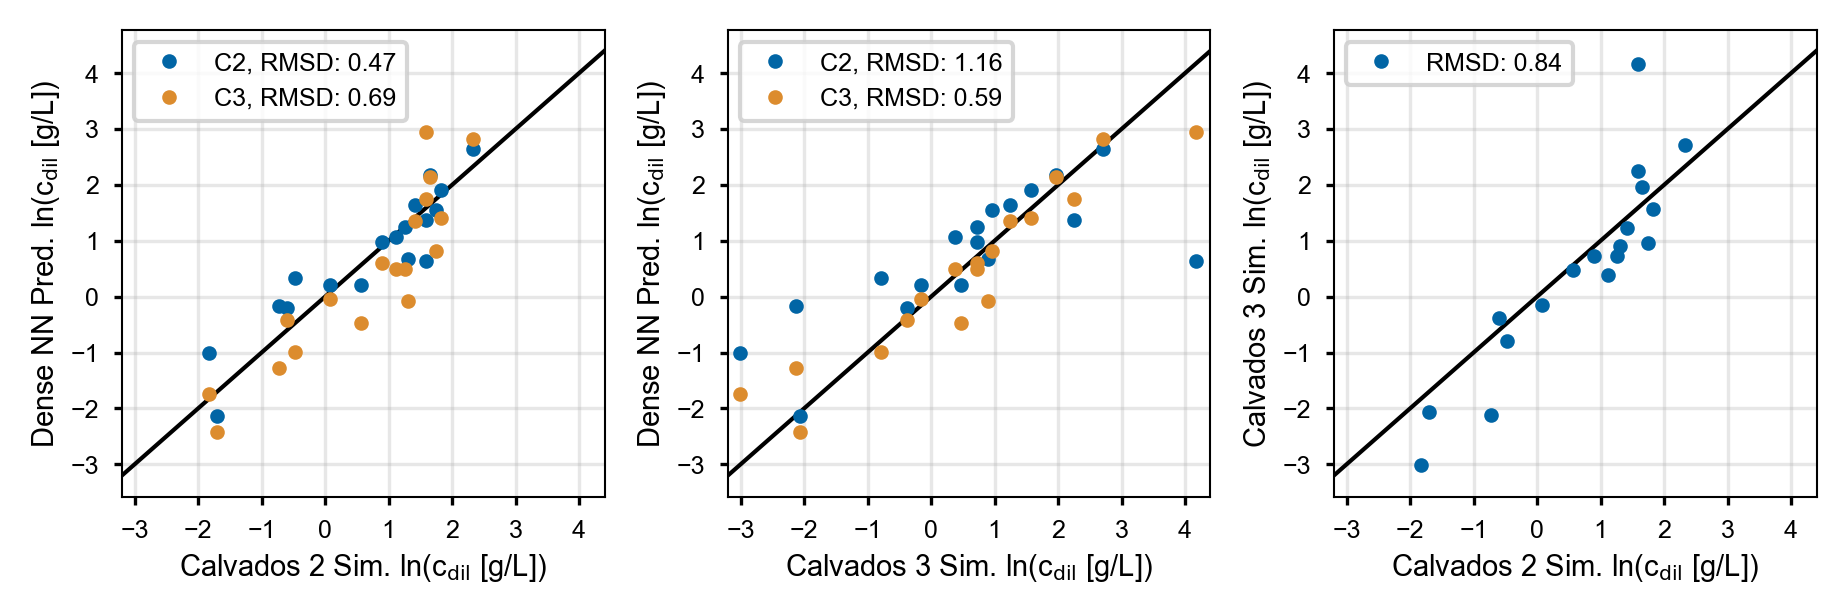

In [83]:
model = models['idrome90']['mlp']['logcdil_mgml']

df_c2c3 = pd.read_csv('data_revision/C2_C3_comparison_pred_tested.csv').set_index('name')
print(len(df_c2c3))
df_c2c3.drop('Ddx4WT',inplace=True)
print(len(df_c2c3))

fig, ax = plt.subplots(1,3,figsize=(1.8*col1x,0.6*col1x))
xs = np.arange(-3.2,4.5,0.1)
for idx in range(3):
    ax[idx].plot(xs,xs,color='black')

rp, rs, rmsd = model.calc_statistics(df_c2c3['csat_C2_mgml'], df_c2c3['csat_pred_2'])
ax[0].plot(df_c2c3['csat_C2_mgml'], df_c2c3['csat_pred_2'],'o',c=colors[0],label=f'C2, RMSD: {rmsd:.2f}')
rp, rs, rmsd = model.calc_statistics(df_c2c3['csat_C2_mgml'], df_c2c3['csat_pred_3'])
ax[0].plot(df_c2c3['csat_C2_mgml'], df_c2c3['csat_pred_3'],'o',c=colors[1],label=f'C3, RMSD: {rmsd:.2f}')

rp, rs, rmsd = model.calc_statistics(df_c2c3['csat_C3_mgml'], df_c2c3['csat_pred_2'])
ax[1].plot(df_c2c3['csat_C3_mgml'], df_c2c3['csat_pred_2'],'o',c=colors[0],label=f'C2, RMSD: {rmsd:.2f}')
rp, rs, rmsd = model.calc_statistics(df_c2c3['csat_C3_mgml'], df_c2c3['csat_pred_3'])
ax[1].plot(df_c2c3['csat_C3_mgml'], df_c2c3['csat_pred_3'],'o',c=colors[1],label=f'C3, RMSD: {rmsd:.2f}')

rp, rs, rmsd = model.calc_statistics(df_c2c3['csat_C2_mgml'], df_c2c3['csat_C3_mgml'])
ax[2].plot(df_c2c3['csat_C2_mgml'], df_c2c3['csat_C3_mgml'],'o',c=colors[0],label=f'RMSD: {rmsd:.2f}')
for idx in range(3):
    ax[idx].set(xlim=(xs[0],xs[-1]))
    ax[idx].legend(fontsize=6)
    ax[idx].set_xticks(np.arange(-3,4.1,1))
    ax[idx].set_yticks(np.arange(-3,4.1,1))

ax[0].set(xlabel=f'Calvados 2 Sim. {targets_clean["logcdil_mgml"]}')
ax[0].set(ylabel=f'Dense NN Pred. {targets_clean["logcdil_mgml"]}')
ax[1].set(xlabel=f'Calvados 3 Sim. {targets_clean["logcdil_mgml"]}')
ax[1].set(ylabel=f'Dense NN Pred. {targets_clean["logcdil_mgml"]}')

ax[2].set(xlabel=f'Calvados 2 Sim. {targets_clean["logcdil_mgml"]}')
ax[2].set(ylabel=f'Calvados 3 Sim. {targets_clean["logcdil_mgml"]}')

fig.tight_layout()
# fig.savefig('figures_revision/figS_C2_vs_C3.pdf')

# Fig. S7: Single-chain sims (Trp)

In [36]:
import blocking
def rg_with_error(u,ag,residues,start=100,step=1):
    rgs = cal.analysis.calc_rg(u,ag,ag.resnames.tolist(),residues,start=start,step=step)
    block_rg = blocking.main.BlockAnalysis(rgs)
    block_rg.SEM()
    return np.mean(rgs), block_rg.sem

In [39]:
# path = 'tanja/single_chain_Trp/'
residues_modTrp = pd.read_csv('data_revision/single_chain_Trp/residues_CALVADOS2_Trp1.48.csv').set_index('one')
df_single_chain = pd.read_csv('data_revision/single_chain_Trp/single_chain_Trp.csv',index_col='name')
# df_single_chain

Original C2
Pearson: 0.962, Spearman: 0.959, RMSD: 0.337
Trp1.48
Pearson: 0.962, Spearman: 0.955, RMSD: 0.345


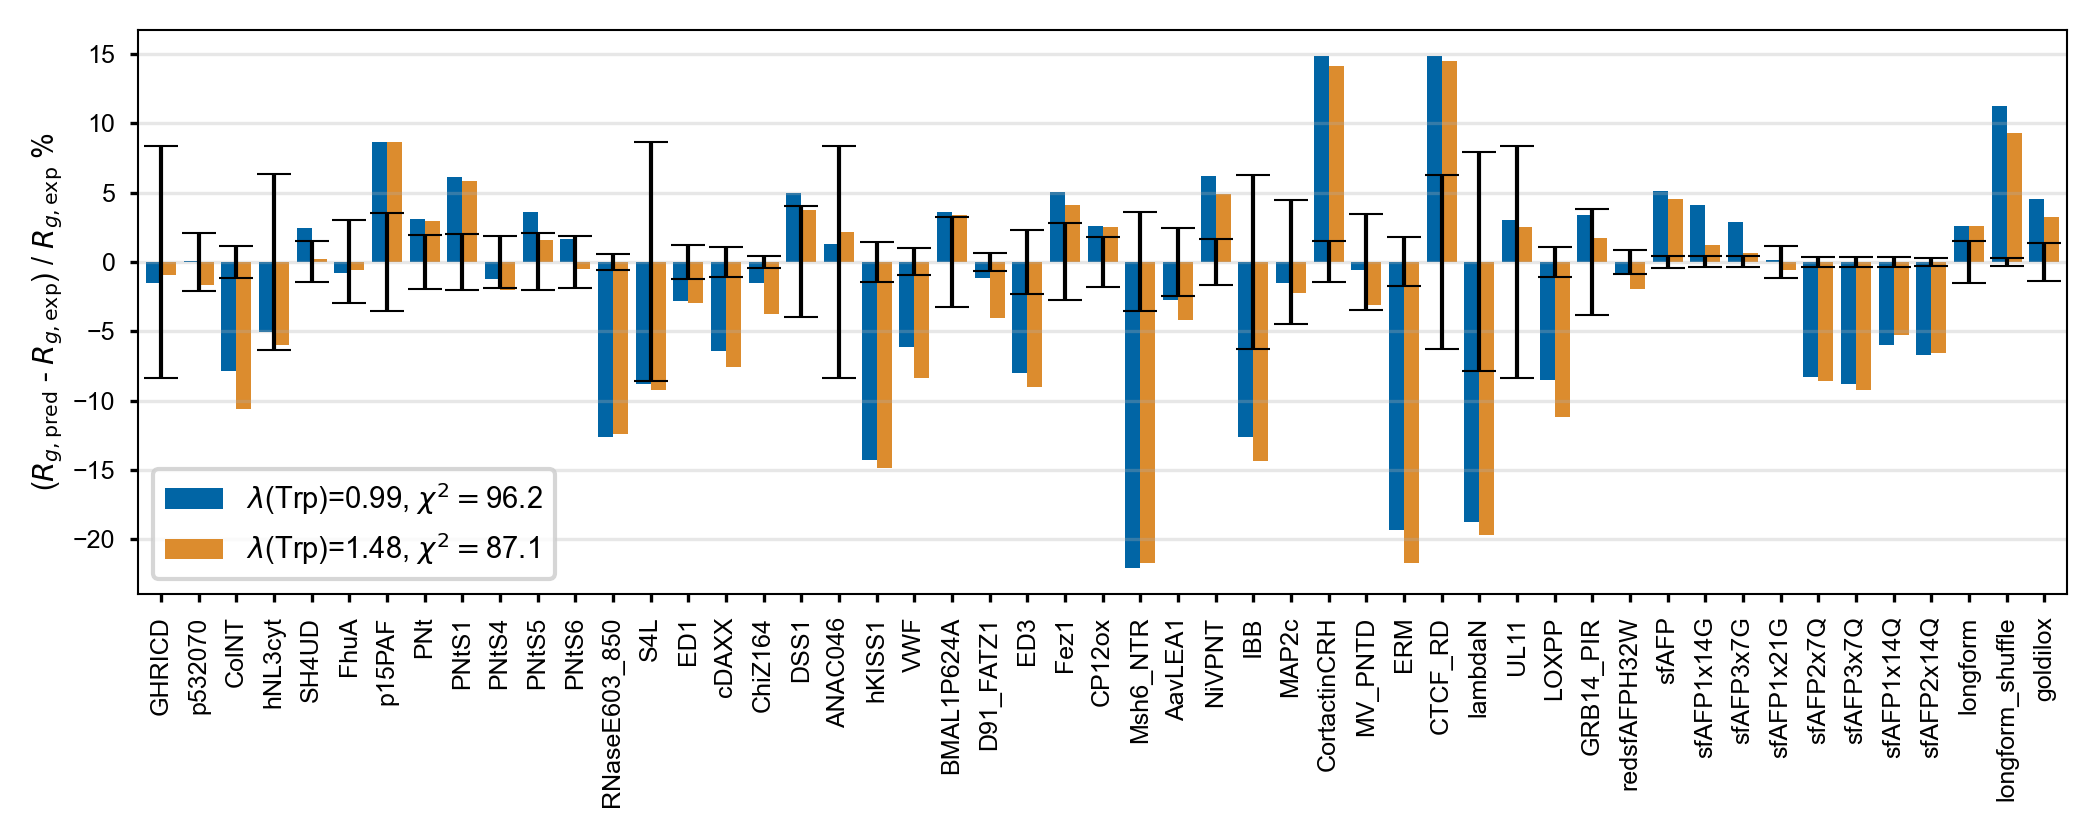

In [41]:
exp_rg = df_single_chain['exp_rg'].values
exp_rg_err = df_single_chain['exp_rg_err'].values
sim_rg_C2 = df_single_chain['sim_rg_C2'].values
sim_rg_err_C2 = df_single_chain['sim_rg_err_C2']
sim_rg_new = df_single_chain['sim_rg_Trp1.48'].values
sim_rg_err_new = df_single_chain['sim_rg_err_Trp1.48']

rel_signed_err_C2 = (sim_rg_C2 - exp_rg) / exp_rg * 100
rel_signed_err_new = (sim_rg_new - exp_rg) / exp_rg * 100 
rel_exp_err = exp_rg_err / exp_rg * 100

print('Original C2')
rp, rs, rmsd_orig = model.calc_statistics(exp_rg, sim_rg_C2)
print('Trp1.48')
rp, rs, rmsd_new = model.calc_statistics(exp_rg, sim_rg_new)

chi2_orig = ((sim_rg_C2 - exp_rg) / exp_rg_err)**2
chi2_orig = np.mean(chi2_orig) 

chi2_new = ((sim_rg_new - exp_rg) / exp_rg_err)**2
chi2_new = np.mean(chi2_new) 

N = len(df_single_chain)

fig, ax = plt.subplots(figsize=(col2x,4/10*col2x))

xs = np.arange(len(rel_signed_err_C2))*2.5
ax.bar(xs, rel_signed_err_C2,
    label=f'$\lambda$(Trp)={residues.lambdas["W"]:.2f}, $\chi^2=${chi2_orig:.1f}',color=colors[0],
       width=1.0)
ax.bar(xs+1, rel_signed_err_new,
    label=f'$\lambda$(Trp)={residues_modTrp.lambdas["W"]:.2f}, $\chi^2=${chi2_new:.1f}',
      color=colors[1],width=1.0)
ax.errorbar(xs+0.5,np.zeros(N),yerr=rel_exp_err, c='black',ls='none',capsize=4,alpha=1.)

ax.set_xticks(xs+0.5)
ax.set_xticklabels(df_single_chain.index,rotation=90)
ax.set_yticks(np.arange(-20,16,5))
ax.set(xlim=(xs[0]-1,xs[-1]+2))
ax.set(ylabel='($R_{g,\mathrm{pred}}$ - $R_{g,\mathrm{exp}}$) / $R_{g,\mathrm{exp}}$ %')
ax.legend()
ax.grid(axis='x')#alpha=0.3)#ydata=[])
fig.tight_layout()
# fig.savefig('figures_revision/figS_single_chain.pdf')

# Convergence

## Cross-validation convergence

In [92]:
def prep_convergence(df_input, df_full, features, simulated, target):
    df_temp = df_input[features + [target]].dropna()
    
    print(len(simulated))
    simulated_clean = [] # keys without skiplist
    for key in simulated:
        name = df_full.loc[key,'seq_name']
        if name not in skiplist:
            if name in df_temp.index:
                simulated_clean.append(key)
    print(len(simulated_clean))
    
    # Start from ECT + Giulio
    df_seed = df_temp.copy()
    
    # define seed of ECT + Giulio
    for sim in simulated_clean:
        name = df_full.loc[sim,'seq_name']

        if name in df_temp.index:
            df_seed.drop(name,inplace=True)
    print(f'Number of seed simulations: {len(df_seed)}')
    return simulated_clean, df_temp, df_seed

In [93]:
mltype = 'mlp'
target = 'logcdil_mgml'

print(target)
print(features)

simulated_clean, df_temp, df_seed = prep_convergence(df_merged, df_full, features, simulated, target)

logcdil_mgml
['mean_lambda', 'faro', 'shd', 'ncpr', 'fcr', 'scd', 'ah_ij', 'nu_svr']
316
304
Number of seed simulations: 58


In [103]:
ncrossval = 30
verbose = False
fcolor = plt.cm.summer

alpha = 5
layers = (10,10)#(5,5)
C = 10.
epsilon = 1e-2

rps = []
rss = []
rmsds = []

models_tmp = []

ndfs = np.arange(0,len(simulated_clean)+1,5)

for idx, ndf in tqdm(enumerate(ndfs),total=len(ndfs)):
    df_reduced = df_seed.copy()

    for sim in simulated_clean[:ndf]:
        name = df_full.loc[sim,'seq_name']
        df_reduced.loc[name] = df_temp.loc[name]

    X, y, X_keys = makeXy(df_reduced, features, target=target)

    model = Model(
        mltype = mltype,
        C = C,
        epsilon = epsilon,
        layers = layers,
        alpha = alpha,
        ncrossval = ncrossval
    )

    model.train(X,y,X_keys,verbose=verbose)

    models_tmp.append(model)

    rps.append(model.rp_mean)
    rss.append(model.rs_mean)
    rmsds.append(model.rmsd_mean)

rps = np.array(rps)
rss = np.array(rss)
rmsds = np.array(rmsds)


00%|███████████████████████████████████████████| 61/61 [01:20<00:00,  1.32s/it]

## Fig. S1: Crossvalidation convergence

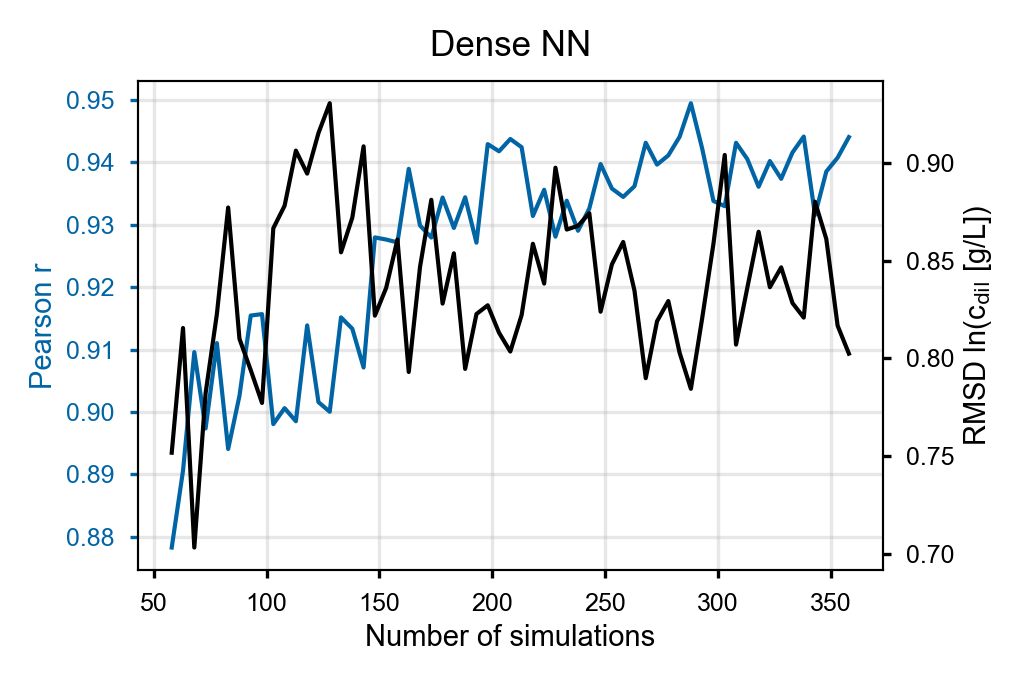

In [104]:
fig, ax = plt.subplots(figsize=(col1x,3/4.5*col1x))#,sharey='col')#,sharex='col')

axij = ax
axtwin = axij.twinx()

axij.plot(ndfs+len(df_seed), rps[:], label='Pearson R',c=colors[0])

axtwin.plot(ndfs+len(df_seed), rmsds[:], label='rmsd', color='black')

axij.set(xlabel='Number of simulations')
axij.set_ylabel('Pearson r',color=colors[0])

axij.grid(alpha=0.3)

axtwin.set(ylabel=f'RMSD {targets_clean[target]}')
axtwin.grid(False)
axij.yaxis.label.set_color(colors[0])
axij.tick_params(axis='y', colors=colors[0])

axij.set(title=mltypes_clean[mltype])

fig.tight_layout()

## Fig. 1B: Validation set (IDRome90) convergence

In [98]:
mltype = 'mlp'
target = 'logcdil_mgml'#'dG'

print(target)
print(features)

simulated_clean, df_temp, df_seed = prep_convergence(df_merged, df_full, features, simulated, target)

df_temp_valid_intra = df_valid_intra[features + [target]].dropna()

logcdil_mgml
['mean_lambda', 'faro', 'shd', 'ncpr', 'fcr', 'scd', 'ah_ij', 'nu_svr']
316
304
Number of seed simulations: 58


In [99]:
print(target)

ncrossval = 30
# nresample = 10
verbose = False
fcolor = plt.cm.summer

rps = []
rss = []
rmsds = []

y_vals = []
ypred_vals = []

ndfs = np.arange(0,len(simulated_clean)+1,5)

for idx, ndf in tqdm(enumerate(ndfs),total=len(ndfs)):
    # print(f'ndf: {ndf}')
    df_reduced = df_seed.copy()

    for sim in simulated_clean[:ndf]:
        name = df_full.loc[sim,'seq_name']
        df_reduced.loc[name] = df_temp.loc[name]

    X, y, X_keys = makeXy(df_reduced, features, target=target)
    X_val, y_val, X_val_keys = makeXy(df_temp_valid_intra, features, target=target)
    X_val_keys = np.array(X_val_keys,dtype='object')
    
    model = Model(
        mltype = mltype,
        C = C,
        epsilon = epsilon,
        layers = layers,
        alpha = alpha,
        ncrossval = ncrossval
    )
    model.train(X,y,X_keys,verbose=verbose)

    ypred_val = model.predict(X_val)

    outliers = np.where(np.abs(np.mean(ypred_val,axis=0) - y_val) > 3)[0]

    rp, rs, rmsd = model.calc_statistics_multimodel(y_val, ypred_val,verbose=verbose)

    rps.append(np.mean(rp))
    rss.append(np.mean(rs))
    rmsds.append(np.mean(rmsd))
    y_vals.append(y_val)
    ypred_vals.append(ypred_val)
        
rps = np.array(rps)
rss = np.array(rss)
rmsds = np.array(rmsds)
y_vals = np.array(y_vals)
ypred_vals = np.array(ypred_vals)

logcdil_mgml



00%|███████████████████████████████████████████| 61/61 [01:25<00:00,  1.41s/it]

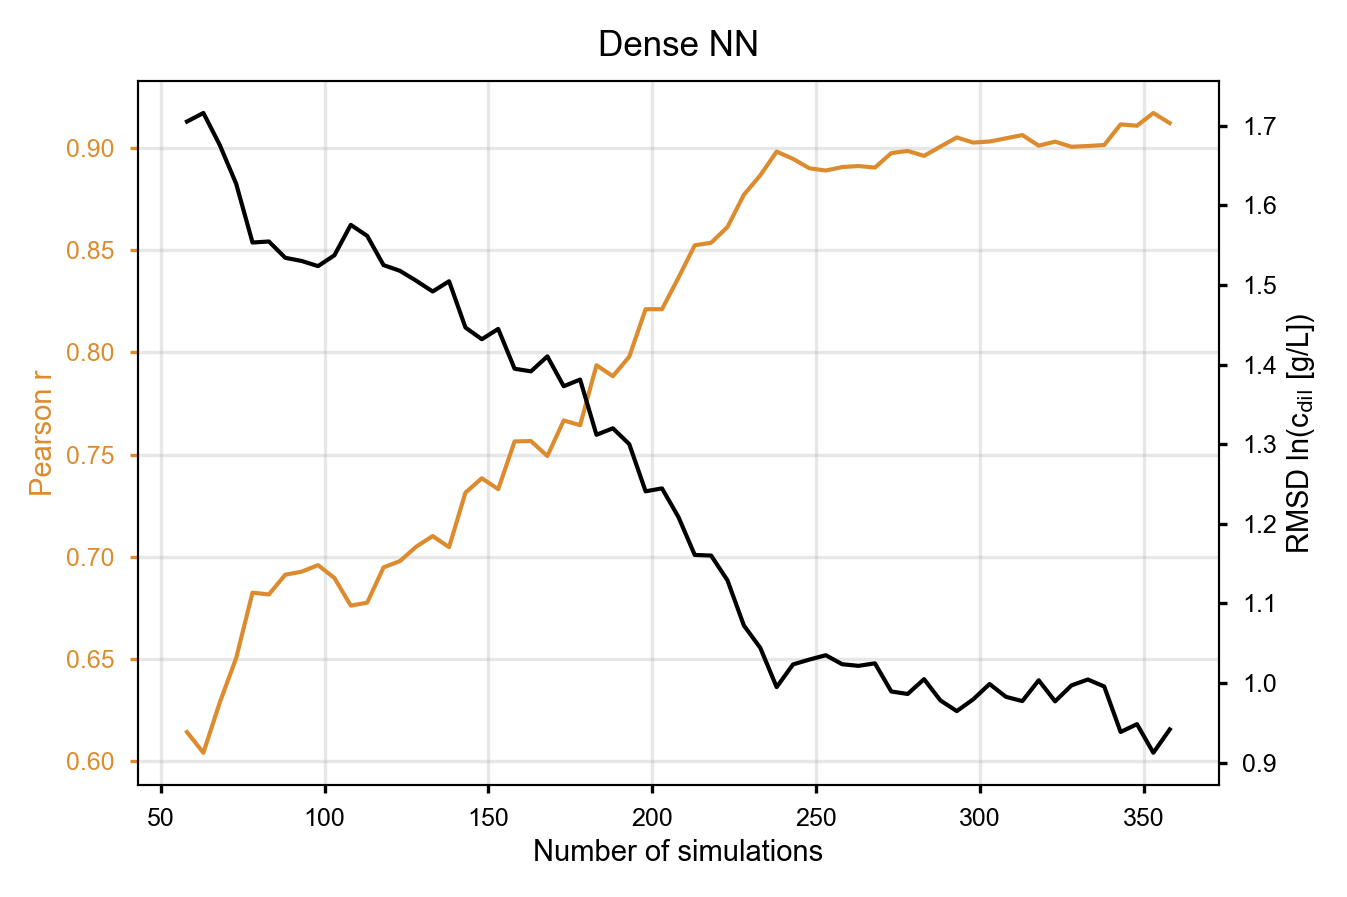

In [101]:
fig, ax = plt.subplots(figsize=(4.5,3))#,sharey='col')#,sharex='col')

axij = ax

axtwin = axij.twinx()

axij.plot(ndfs+len(df_seed), rps, label='Pearson R',c=colors[1])
axtwin.plot(ndfs+len(df_seed), rmsds, label='rmsd', color='black')

for jdx, ndf in enumerate(ndfs):
    yv_m = y_vals[jdx]
    yp = ypred_vals[jdx]
    yp_m = np.mean(yp,axis=0)
    yp_std = np.std(yp,axis=0)

axij.set(xlabel='Number of simulations')
axij.set_ylabel('Pearson r',color=colors[0])

axij.grid(alpha=0.3)

axtwin.set(ylabel=f'RMSD {targets_clean[target]}')
axtwin.grid(False)
axij.yaxis.label.set_color(colors[1])
axij.tick_params(axis='y', colors=colors[1])

axij.set(title=mltypes_clean[mltype])

fig.tight_layout()

# Distributions

## Fig. 4: dG distributions (1D)

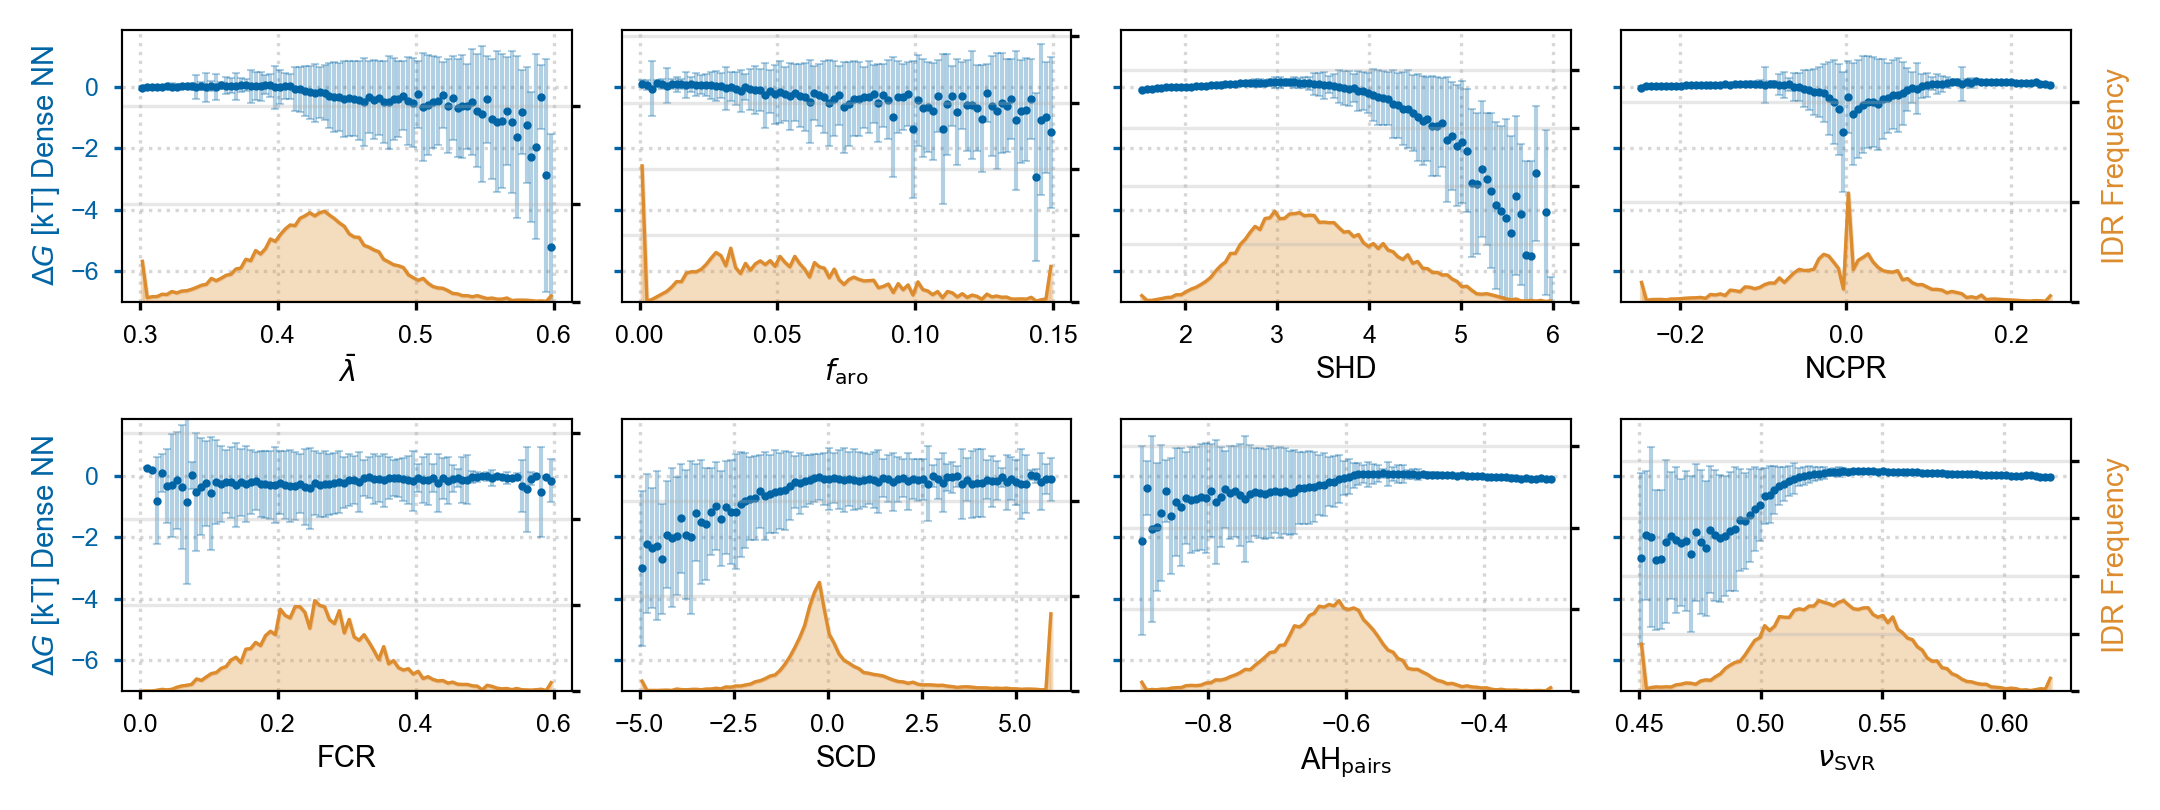

In [24]:
# if target == 'dG':
#     target_clean = r'$\Delta G$'
# elif target == 'dG_logist':
#     target_clean = r'$f\,(\Delta G)$'
target = 'dG'
mltype = 'mlp'

nbins = 84

fcolor_r = plt.cm.summer_r
fcolor_r = plt.cm.viridis_r

Nfeat = len(features)

fig, ax = plt.subplots(2,4,figsize=(col2x,2.5),sharey=True)

# example_key = 4227
# example = None #13664

for idx, feat in enumerate(features):
    # print(feat)
    axij = ax[idx//4,idx%4]
    
    xs = df_full[feat].to_numpy()
    ys = df_full['dG_pred'].to_numpy()
    if feat in limits:
        drange = limits[feat]
    else:
        drange = None
    edges, y_binned = bin_data(xs,ys,nbins,drange=drange)
    edges = (edges[:-1] + edges[1:]) / 2.

    # print(edges)
    y_mean = np.array([np.mean(y) for y in y_binned])
    y_std = np.array([np.std(y) for y in y_binned])
    yLs = np.array([len(yb) for yb in y_binned])

    # if example != None:
        # axij.plot(df.loc[example_key,feat],ys[example],'o',color='tab:red')

    for e, ym, ys, yL in zip(edges,y_mean,y_std,yLs):
        # color = fcolor_r(min(0.5,yL/(1.05*max(yLs))))
        color = colors[0]
        markers, caps, bars = axij.errorbar(e,ym,yerr=ys,capsize=1,marker='.',color=color,zorder=10)
        # markers, caps, bars = ax[idx].errorbar(edges,y_mean,yerr=y_std,capsize=3,marker='.')
    # loop through bars and  caps and set the alpha value
        [bar.set_alpha(0.3) for bar in bars]
        [cap.set_alpha(0.3) for cap in caps]

    ax2 = axij.twinx()
    ax2.plot(edges,yLs,lw=0.8,alpha=1.,color=colors[1])#'black')
    ax2.fill_between(edges,yLs,alpha=0.3,color=colors[1])#'black')
    if idx in [3,7]:
        ax2.set_ylabel('IDR Frequency',color=colors[1])
    if feat == 'faro':
        ax2.set(ylim=(0,max(yLs)*2))
    elif feat in ['scd', 'ncpr']:
        ax2.set(ylim=(0,max(yLs)*2.5))
    else:
        ax2.set(ylim=(0,max(yLs)*3))
    # ax2.set_yticks([])
    ax2.set_yticklabels([])
    
    axij.set(xlabel=features_clean[feat])
    axij.set(ylim=(-7,None))
    axij.tick_params(axis='y', colors=colors[0])#fcolor_r(0.5))
    # ax[idx].set_yticklabels(ax[idx].get_yticklabels(),color=fcolor_r(0))
    axij.grid(ls='dotted',alpha=0.5)

for idx in range(2):
    ax[idx,0].set_ylabel(f'{targets_clean[target]} {mltypes_clean[mltype]}',color=colors[0])#,fontsize=10)#fcolor_r(0.5))
fig.tight_layout(pad=0,w_pad=1.08,h_pad=1.08)#
# fig.savefig(f'figures_revision/fig4_new.pdf')

## SI Figs. S9 & S10: dG distributions 2D

In [91]:
def select_bin(x,bins,nbins):
    if x < bins[0]:
        return -100
        # bin_idx = 0
    elif x > bins[-1]:
        return -100
        # bin_idx = nbins-1
    else:
        for idx in range(nbins):
            if x >= bins[idx] and x <= bins[idx+1]:
                bin_idx = idx
    return bin_idx

def bin_data_2d(xs0, xs1, ys, nbins, dranges=None):
    if dranges == None:
        xmin0, xmax0 = np.min(xs0), np.max(xs0)
        xmin1, xmax1 = np.min(xs1), np.max(xs1)
    else:
        xmin0, xmax0 = dranges[0][0], dranges[0][1]
        xmin1, xmax1 = dranges[1][0], dranges[1][1]
    
    bins0 = np.linspace(xmin0,xmax0,nbins+1)
    bins1 = np.linspace(xmin1,xmax1,nbins+1)
    y_binned = []
    # y_binned = [[] for _ in range(nbins)]
    for idx in range(nbins):
        y_binned.append([[] for _ in range(nbins)])

    for x0, x1, y in zip(xs0, xs1, ys):
        bin_idx0 = select_bin(x0,bins0,nbins)
        bin_idx1 = select_bin(x1,bins1,nbins)
        if (bin_idx0 >= 0) and (bin_idx1 >= 1):
            y_binned[bin_idx0][bin_idx1].append(y)

    y_binned_m = np.zeros((nbins,nbins))
    
    for idx in range(nbins):
        for jdx in range(nbins):
            y_binned_m[idx,jdx] = np.mean(y_binned[idx][jdx])
    return bins0, bins1, y_binned_m

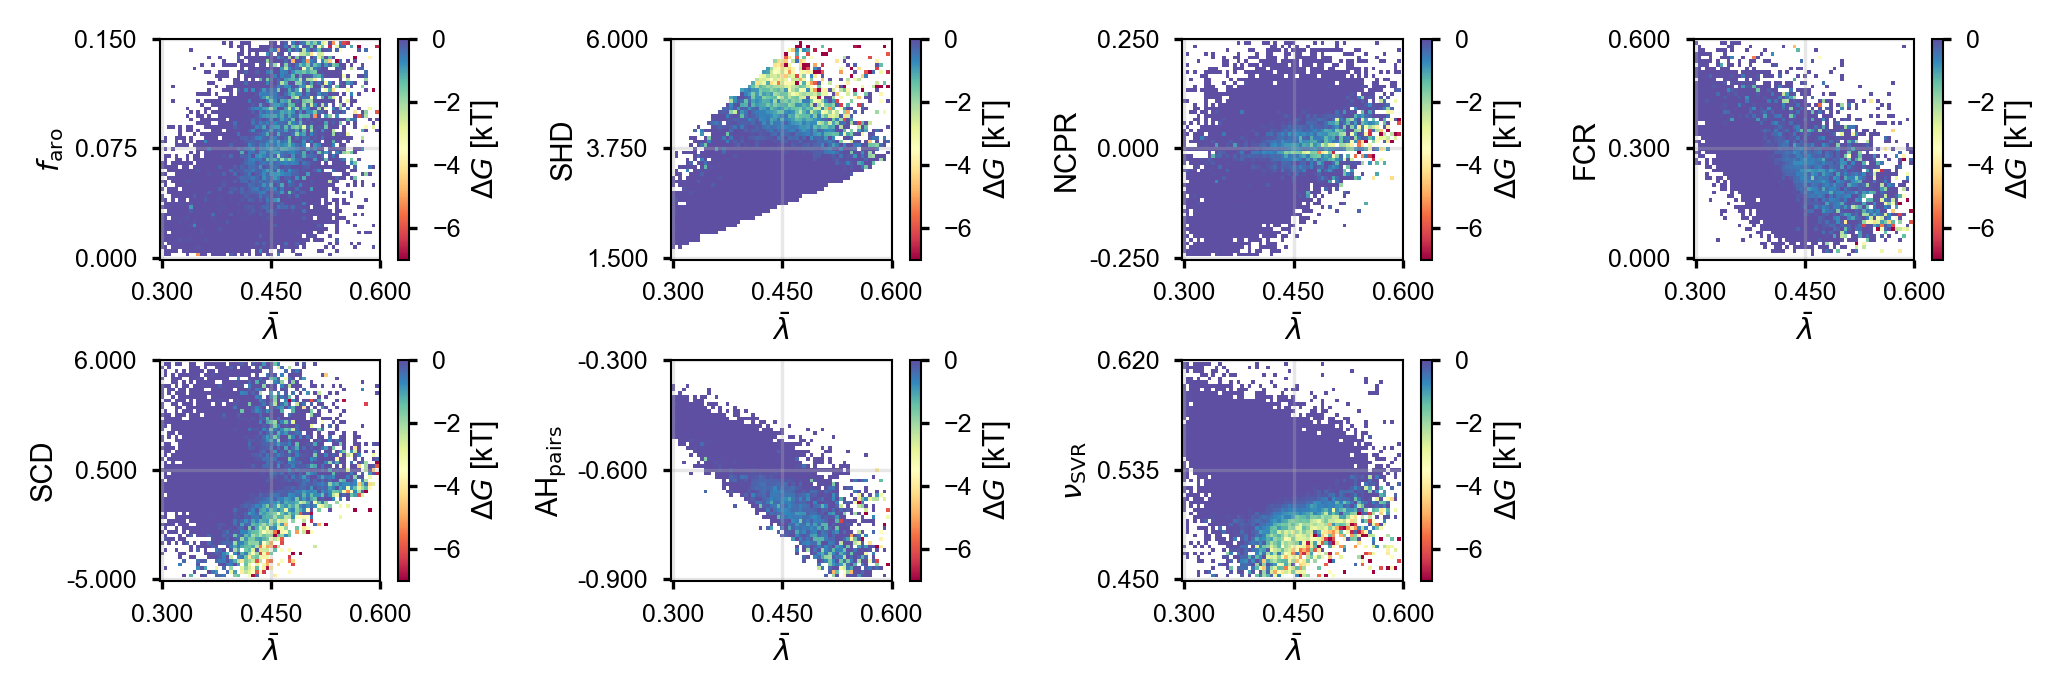

In [27]:
features_2d = features.copy()
# features_2d.remove('mw')

target = 'dG'
mlmodel = 'mlp'

ys = df_full['dG_pred']

nbins = 60 # 60
vmin = -7 # -7
vmax = 0.

idx_offset = 0

fig, ax = plt.subplots(2,4,figsize=(col2x, col2x/3))#12,4))#,width_ratios=[1,1,1,2])

feat0 = 'mean_lambda'#'mean_lambda'#'ah_shd'# 'mean_lambda' #'mean_lambda'#'ah_patch'

xs0 = df_full[feat0].to_numpy()
for idx, feat1 in enumerate(features_2d):
    if feat1 == feat0:
        idx_offset -= 1
        continue

    axij = ax[(idx+idx_offset)//4,(idx+idx_offset)%4]

    xs1 = df_full[feat1].to_numpy()

    # if feat1 == feat0:
    #     axij.set_visible(False)
    #     continue

    dranges = [
        limits[feat0],
        limits[feat1]
    ]

    edges0, edges1, y_binned_2d = bin_data_2d(xs0, xs1, ys, nbins, dranges=dranges)

    _ = axij.imshow(y_binned_2d.T,extent=None,cmap=plt.cm.Spectral,origin='lower',
                   vmin=vmin,vmax=vmax)#,aspect='auto')

    # if (idx+idx_offset) in [3,6]:
    fig.colorbar(_,ax=axij,label=targets_clean[target])
    axij.set(xlabel=features_clean[feat0],ylabel=features_clean[feat1])

    xt = [0,nbins//2,nbins]#np.arange(0,nbins,20)
    axij.set_xticks(xt)
    axij.set_xticklabels([f'{e:.3f}' for e in edges0[xt]])
    axij.set_yticks(xt)
    axij.set_yticklabels([f'{e:.3f}' for e in edges1[xt]])

# ax[-1,-3].set_visible(False)
ax[-1,-1].set_visible(False)
fig.tight_layout(h_pad=0.2,w_pad=0.05)
# fig.savefig(f'figures_revision/figS_plot2D_{target}_{feat0}.pdf')

## Fig. S8: IDRome distribution

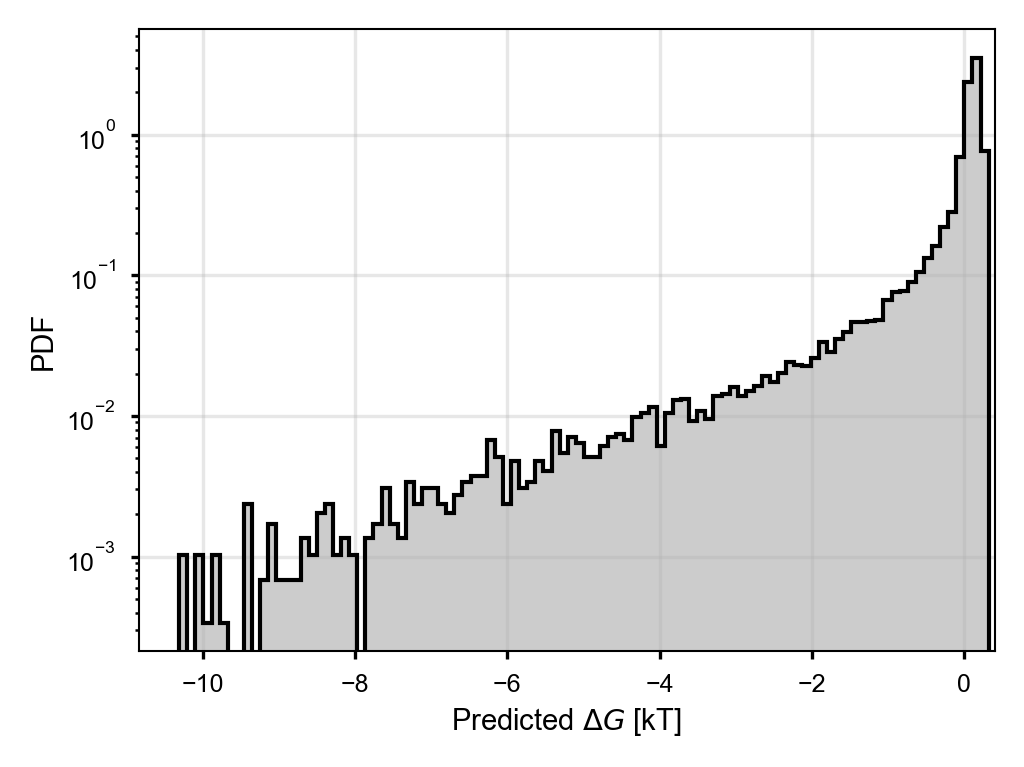

In [29]:
fig, ax = plt.subplots(figsize=(col1x,3/4*col1x))

target = 'dG'
model = models['idrome90']['mlp'][target]

# for idx, d in enumerate([df,df10]):
ax.hist(df_full['dG_pred'],bins=100,histtype='step',density=True,color='black')
ax.hist(df_full['dG_pred'],bins=100,alpha=0.2,density=True,color='black')

ax.set(yscale='log')
ax.grid(alpha=0.3)
ax.set(xlabel=f'Predicted {targets_clean[target]}',ylabel='PDF')
ax.set(xlim=(None,0.4))
# ax.legend()
fig.tight_layout()
# fig.savefig(f'figures_revision/figS_IDRome_{target}_distribution.pdf')

# Skipped sequences

## Fig. S14: Density maps

15
Q5HYW3_413_569 (1627, 200)
P51861_1_262 (1344, 200)
Q9NYF8_1_593 (898, 300)
P98179_78_157 (979, 200)
Q13936_420_515 (1188, 200)
Q1KMD3_636_747 (870, 200)
O60841_1_608 (1017, 300)
Q9NQX4_794_1370 (933, 300)
Q9ULD5_260_638 (894, 300)
Q86VX9_1_247 (1053, 200)
Q14011_79_172 (989, 200)
P78332_1_467 (849, 300)
Q9Y2H5_158_530 (769, 300)
P38159_87_391 (873, 200)
Q9Y2W1 (1867, 200)


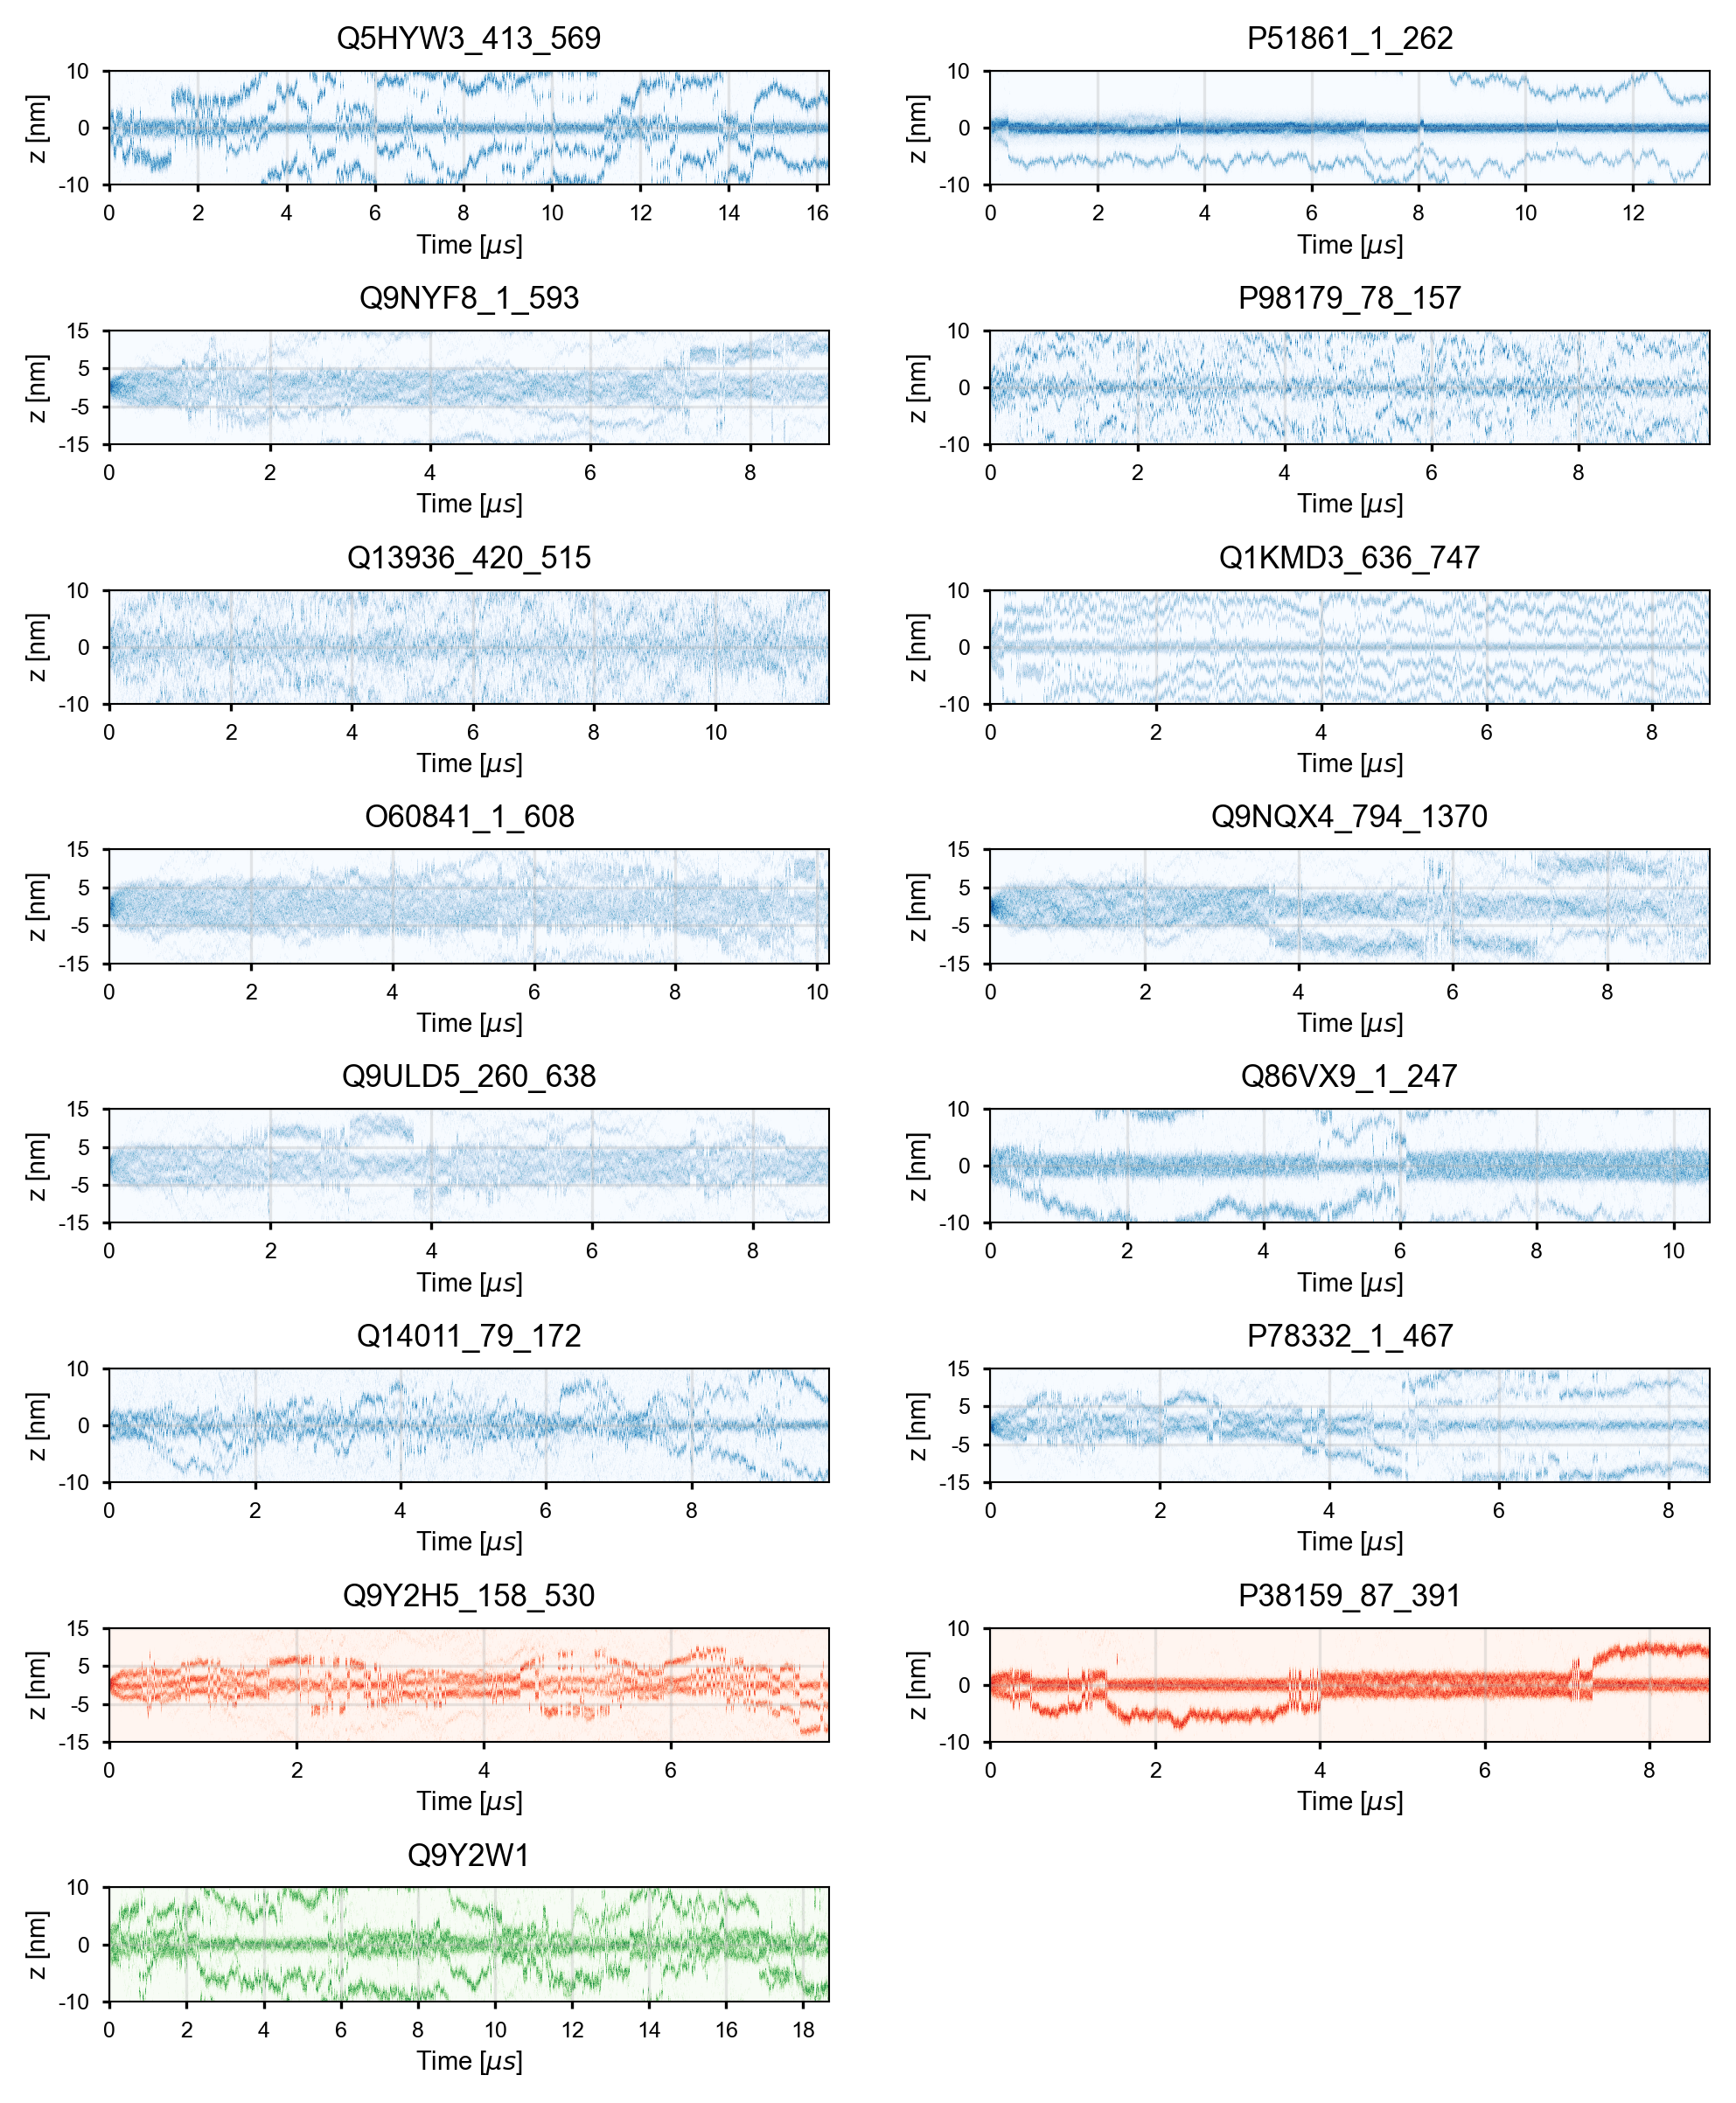

In [42]:
skiplist_densityplot = skiplist_all[:]
skiplist_densityplot.append('Q9Y2W1')

from matplotlib.ticker import FormatStrFormatter
nskip = len(skiplist_densityplot)

print(nskip)
fig, ax = plt.subplots(nskip//2+1,2,figsize=(col2x,0.56*nskip))#,height_ratios=np.ones((nskip//2)))#,width_ratios=np.ones((nskip)))#,sharey=True)
for idx, name in enumerate(skiplist_densityplot):
    axij = ax[idx//2,idx%2]

    hs = np.load(f'data_revision/densitymaps_skipped/{name}.npy')

    print(name, hs.shape)

    if name in valid_10_skiplist:
        cmap = plt.cm.Reds
    elif name == 'Q9Y2W1':
        cmap = plt.cm.Greens
    else:
        cmap = plt.cm.Blues
    axij.pcolor(hs.T,cmap=cmap)#plt.cm.Blues)
    axij.set_title(name)
    axij.set(xlabel=r'Time [$\mu s$]')
    axij.set(ylabel='z [nm]')
    axij.set_anchor('W')

    axij.set_xticks(np.arange(0,hs.shape[0],200))
    xticklabels = np.arange(0,hs.shape[0]/100,2)
    axij.set_xticklabels([f'{xtl:.0f}' for xtl in xticklabels])
    # axij.xaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    
    axij.set_yticks(np.arange(0,hs.shape[1]+1,100))
    yticklabels = np.arange(-0.5*hs.shape[1]/10,0.5*hs.shape[1]/10+1,10)
    axij.set_yticklabels([f'{ytl:.0f}' for ytl in yticklabels])
ax[-1,-1].set_visible(False)
fig.tight_layout(h_pad=1,pad=3)

## Fig. S15: Distribution of skipped sequences

----------
mean_lambda
ttest to I90
0.3062819613731522 0.7634418787119773
ttest to I90_PS
-1.3752223187909394 0.1880920487594107
----------
faro
ttest to I90
0.8606068849392686 0.402691897049715
ttest to I90_PS
-0.8149126408436369 0.4264152027900361
----------
shd
ttest to I90
1.6169209550518229 0.12421804231261817
ttest to I90_PS
-0.7741605629319998 0.4499722842560442
----------
ncpr
ttest to I90
-1.2259184255049094 0.23010398649291594
ttest to I90_PS
4.4359939052171145 0.0004842918674329404
----------
fcr
ttest to I90
3.0190834046368016 0.007025641815746554
ttest to I90_PS
5.570868443790663 2.310339279249317e-05
----------
scd
ttest to I90
-3.3100994265062478 0.001981272283273791
ttest to I90_PS
0.7407169640474256 0.4700207251731626
----------
ah_ij
ttest to I90
-0.9677468348651265 0.3479959423520316
ttest to I90_PS
0.7780004574930163 0.4482208235148639
----------
nu_svr
ttest to I90
-1.331003449421489 0.20283084428371287
ttest to I90_PS
0.01586298557358226 0.9875413332742545
-------

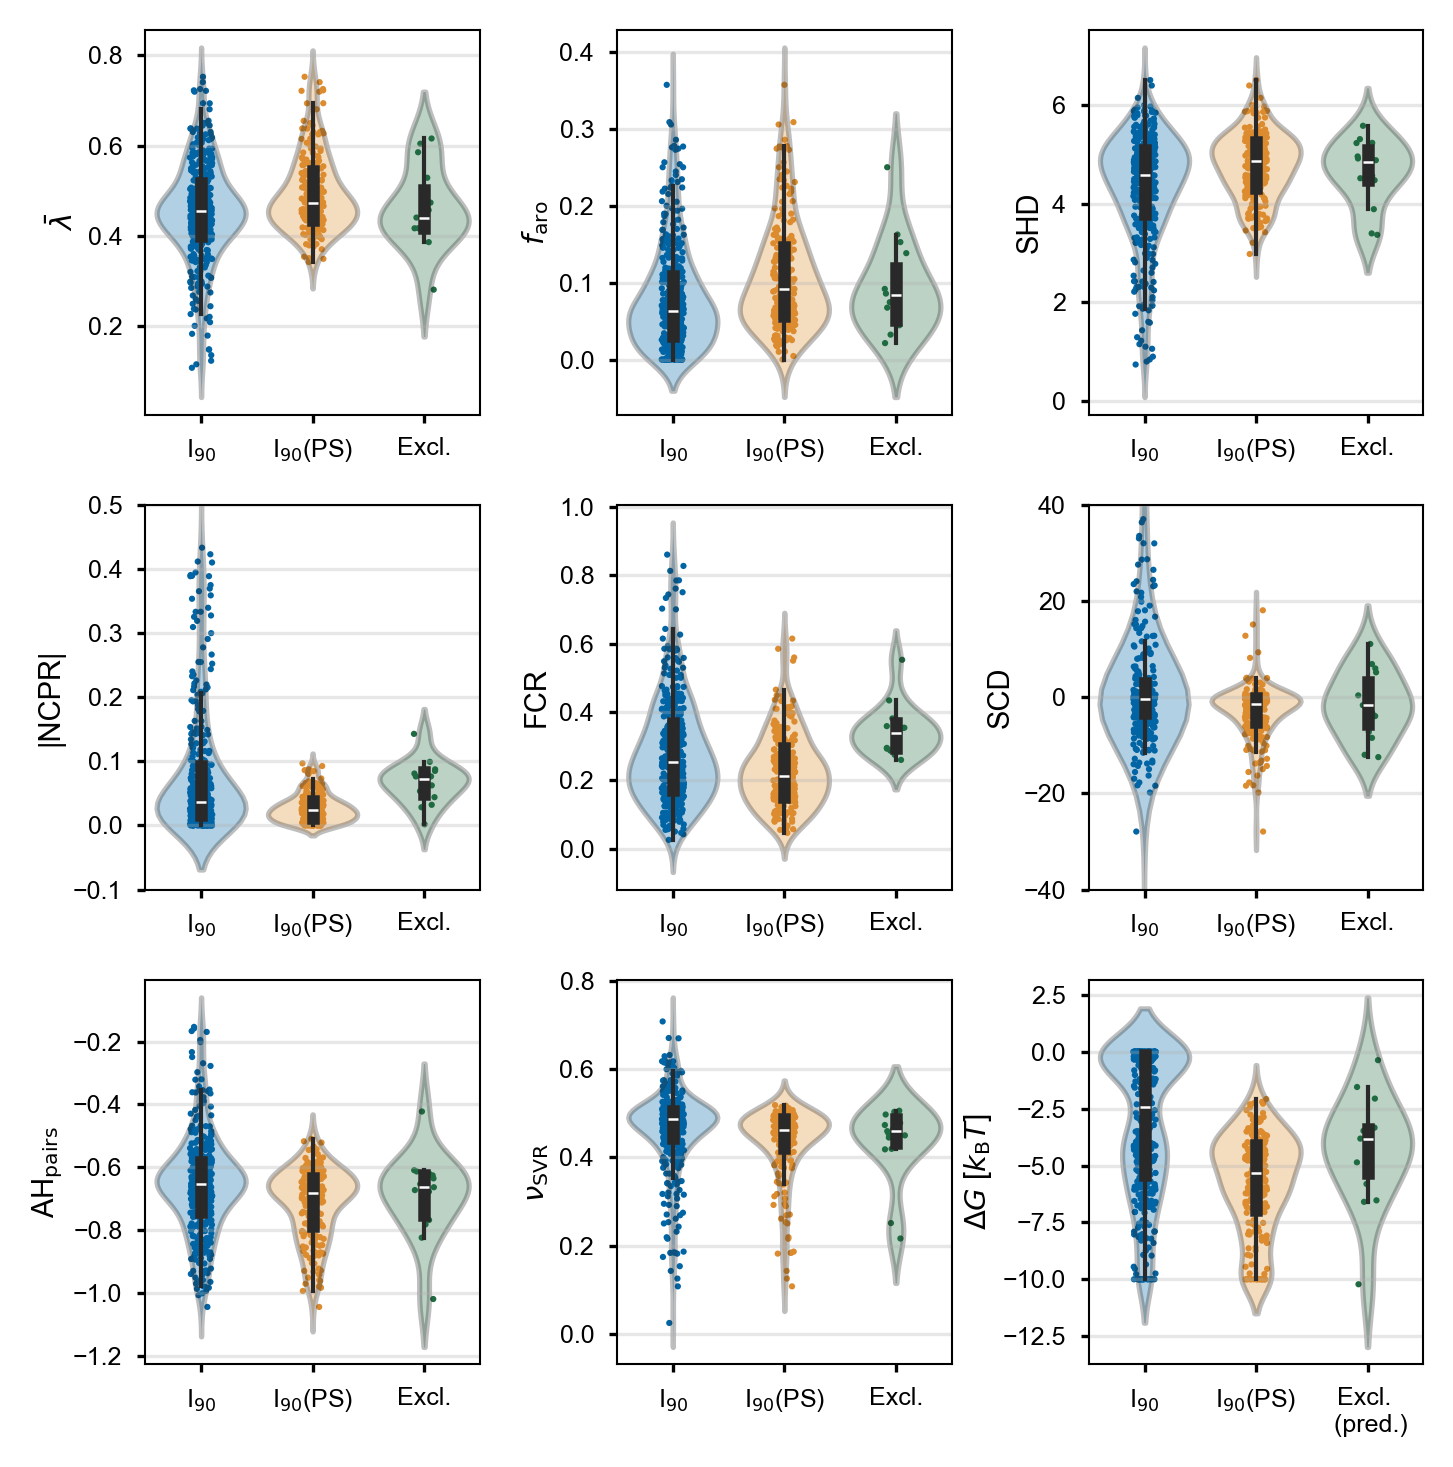

In [38]:
from scipy.stats import ttest_ind

limits_violin = {
    'scd' : [-40,40],
    # 'scd' : [-8,6],
    'ncpr' : [-0.1, 0.5],
}

skiplist_densityplot = skiplist_all[:]
skiplist_densityplot.append('Q9Y2W1')

features_violin = features + ['dG']

fig, ax = plt.subplots(3,3,figsize=(col2x*0.7,col2x*0.7))

for idx, feat in enumerate(features_violin):
    axij = ax[idx//3,idx%3]
    vals_skip = []
    if feat == 'dG':
        featskip = 'dG_pred' # use dG of working sims vs dG_pred of not working
    else:
        featskip = feat
    # dGs_skip = []
    for s in skiplist_densityplot:
        if s == 'Q9Y2W1':
            vals_skip.append(df_csat_exp.loc[s,featskip])
            # dGs_skip.append(df_csat_exp.loc[s,'dG_pred'])
        else:
            key = name_to_index(df_full,s)[0]
            vals_skip.append(df_full.loc[key, featskip])
            # dGs_skip.append(df_full.loc[key,'dG_pred'])
    vals_skip = np.array(vals_skip)
    # dGs_skip = np.array(dGs_skip)
    df_ps = df_merged_with_intra.loc[df_merged_with_intra['dG']<-2]
    # print(len(df_ps))

    I90 = df_merged_with_intra[feat].to_numpy()
    I90_PS = df_ps[feat].to_numpy()

    if feat == 'ncpr':
        I90, I90_PS, vals_skip = np.abs(I90), np.abs(I90_PS), np.abs(vals_skip)
        axij.set(ylabel='|NCPR|')
    else:
        axij.set(ylabel=features_clean[feat])

    vals_all = [I90, I90_PS, vals_skip]
    ttest_I90 = ttest_ind(vals_skip,I90,equal_var=False)
    ttest_I90_PS = ttest_ind(vals_skip,I90_PS,equal_var=False)
    print('----------')
    print(feat)
    print('ttest to I90')
    print(ttest_I90.statistic, ttest_I90.pvalue)
    print('ttest to I90_PS')
    print(ttest_I90_PS.statistic, ttest_I90_PS.pvalue)
    
    # sns.violinplot(df_merged_with_intra[feat].to_numpy(),ax=axij,color=colors[0])
    sns.stripplot(vals_all,ax=axij,palette=colors,marker='.',size=3,zorder=1)
    sns.violinplot(vals_all,ax=axij,palette=colors,saturation=1.,alpha=0.3,
                   inner_kws=dict(box_width=3))#,inner='points')
    
    # sns.stripplot(df_merged_with_intra[feat].to_numpy(),ax=axij,marker='.',color=colors[0])

    # sns.violinplot(vals_skip,ax=axij,color=colors[1])
    # axij.hist(df_merged_with_intra[feat],color='gray',density=True)
    # axij.hist(vals_skip,color='blue',density=True)
    
    if feat in limits_violin:
        axij.set(ylim=(limits_violin[feat][0], limits_violin[feat][1]))
    if feat == 'dG':
        axij.set_xticklabels(['I$_{90}$', 'I$_{90}$(PS)','Excl. \n (pred.)'])
    else:
        axij.set_xticklabels(['I$_{90}$', 'I$_{90}$(PS)','Excl.'])
fig.tight_layout()
# fig.savefig(f'figures_revision/figS_distr_skiplist.pdf')
# ax[1,3].set_ylabel('nm')
# target = 'dG'
# mltype = 'mlp'

# Monte-Carlo

In [61]:
limits_mc = {
    'scd' : [-10,10],
    'ncpr' : [-0.13, 0.13],
    'nu_svr' : [0.25, 0.505],
    'mean_lambda' : [0.35, 0.6],
    'seqJS' : [0, 0.3],
}

def calc_aa_distr(seq):
    aminoacids = "ACDEFGHIKLMNPQRSTVWY"
    # seq = list(seq)
    distr = {}
    for aa in aminoacids:
        distr[aa] = 0
    for s in seq:
        distr[s] += 1
    for aa in aminoacids:
        distr[aa] /= len(seq)
    return distr

## Fig. 5: MC runs

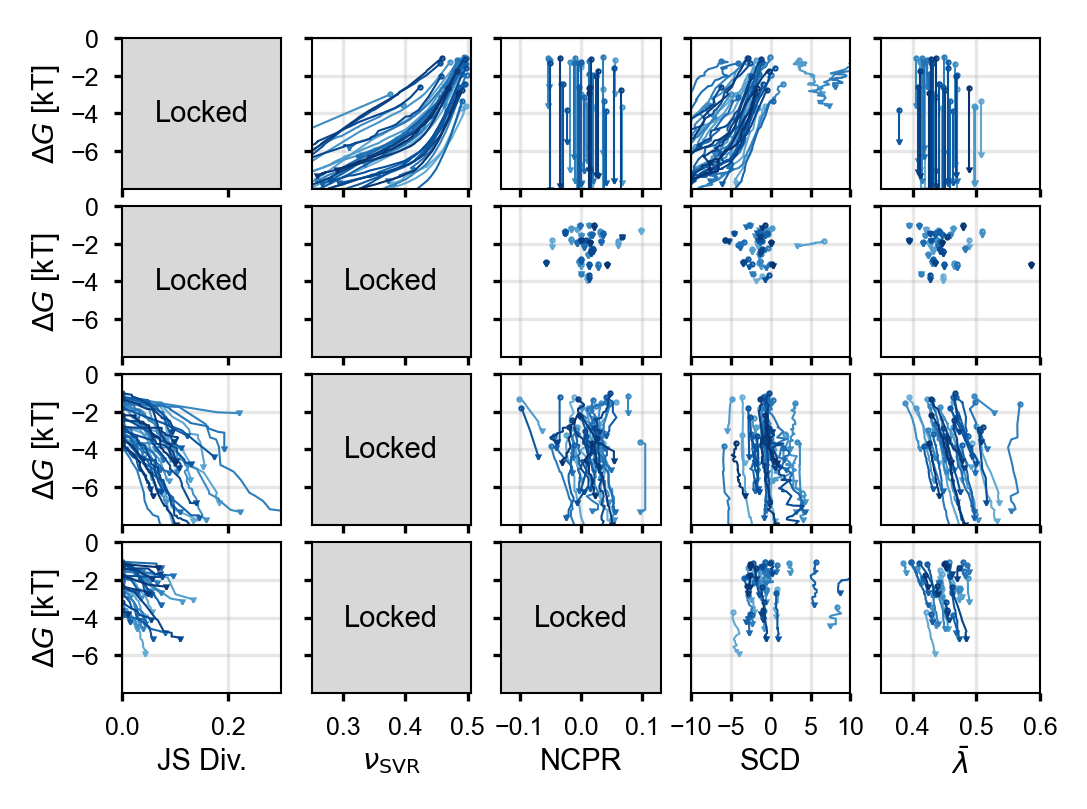

In [62]:
import pickle

nruns = 40 # 100 # 170

constr_combinations = [
    [[], 1.],
    [['nu_svr'], 1.],
    [['nu_svr'], 0.5],
    [['nu_svr','ncpr'], 0.5],
]

cm = plt.cm.Blues

features_plot = ['seqJS','nu_svr','ncpr','scd','mean_lambda'] # , 'faro'

fig, axes = plt.subplots(len(constr_combinations),len(features_plot),figsize=(3.425,2.5),#figsize=(11,9.5), 
                         sharex='col',sharey=True)

for c_idx, (constraints, pswap) in enumerate(constr_combinations):
    while True:
        random.shuffle(constraints)
        ##
        features_extended = features + ['seqid', 'seqJS']
        dir_mc_base = 'data_revision/mc_runs'
        
        if len(constraints) == 0:
            str_constr = 'none'
        else:
            str_constr = "_".join(constraints)
        
        dir_mc = f'{dir_mc_base}/constr_{str_constr}/pswap{pswap:.2f}'
        # print(dir_mc)
        ##
        if os.path.isdir(dir_mc):
            break
    
    aminoacids = "ACDEFGHIKLMNPQRSTVWY"
    res_runs = []

    for idx in range(nruns):
        with open(f'{dir_mc}/run_{idx}.pkl','rb') as f:
            res = pickle.load(f)
            res_runs.append(res)

    for jdx, feat in enumerate(features_plot):
        ax = axes[c_idx, jdx] # axes[jdx, c_idx]  
        if (feat in constraints) or (feat=='seqJS' and pswap==1.):
            ax.set(ylim=[-8,0])
            ax.text(np.mean(limits_mc[feat]),-4,'Locked',fontsize=7,
                    horizontalalignment='center',
                   verticalalignment='center')
            ax.fill_between([-100,100],[-100,-100],[100,100],color='gray',alpha=0.3) # colors[1]
            ax.grid(False)
        else:
            c = colors[0]
            for idx in range(nruns):
                res = res_runs[idx]

                xs = res[feat] #- res[feat][0]
                ys = res['dG'] #- res['dG'][0]
                
                ax.plot(xs[0], ys[0], 'o', fillstyle='none', markersize=1, c=cm(idx/(2*nruns)+0.5)) # c=c,
                ax.plot(xs[-1], ys[-1], 'v', fillstyle='none', markersize=1, c=cm(idx/(2*nruns)+0.5))
                ax.plot(xs, ys,lw=0.5, c=cm(idx/(2*nruns)+0.5)) # c=c,
                
                if feat in limits_mc:
                    ax.set(xlim=limits_mc[feat])
                
                if feat == 'scd':
                    ax.set_xticks(np.arange(-10,10.1,5))
                ax.set_yticks(np.arange(-6,0.1,2))

for c_idx, _ in enumerate(constr_combinations):
    axes[c_idx,0].set_ylabel(f'{targets_clean["dG"]}',fontsize=7)
for jdx, feat in enumerate(features_plot):
    axes[-1,jdx].set_xlabel(features_clean[feat],fontsize=7)
fig.tight_layout(h_pad=0,w_pad=0,pad=0)
# fig.savefig(f'figures_revision/fig5_new.pdf')

## Fig. S13: Extended MC

In [65]:
dlimits_mc = {
    'scd' : [-15,10],
    'ncpr' : [-0.1, 0.1],
    'nu_svr' : [-0.4,0.02],
    'mean_lambda' : [-0.07,0.07],
    'seqJS' : [0, 0.3],
}

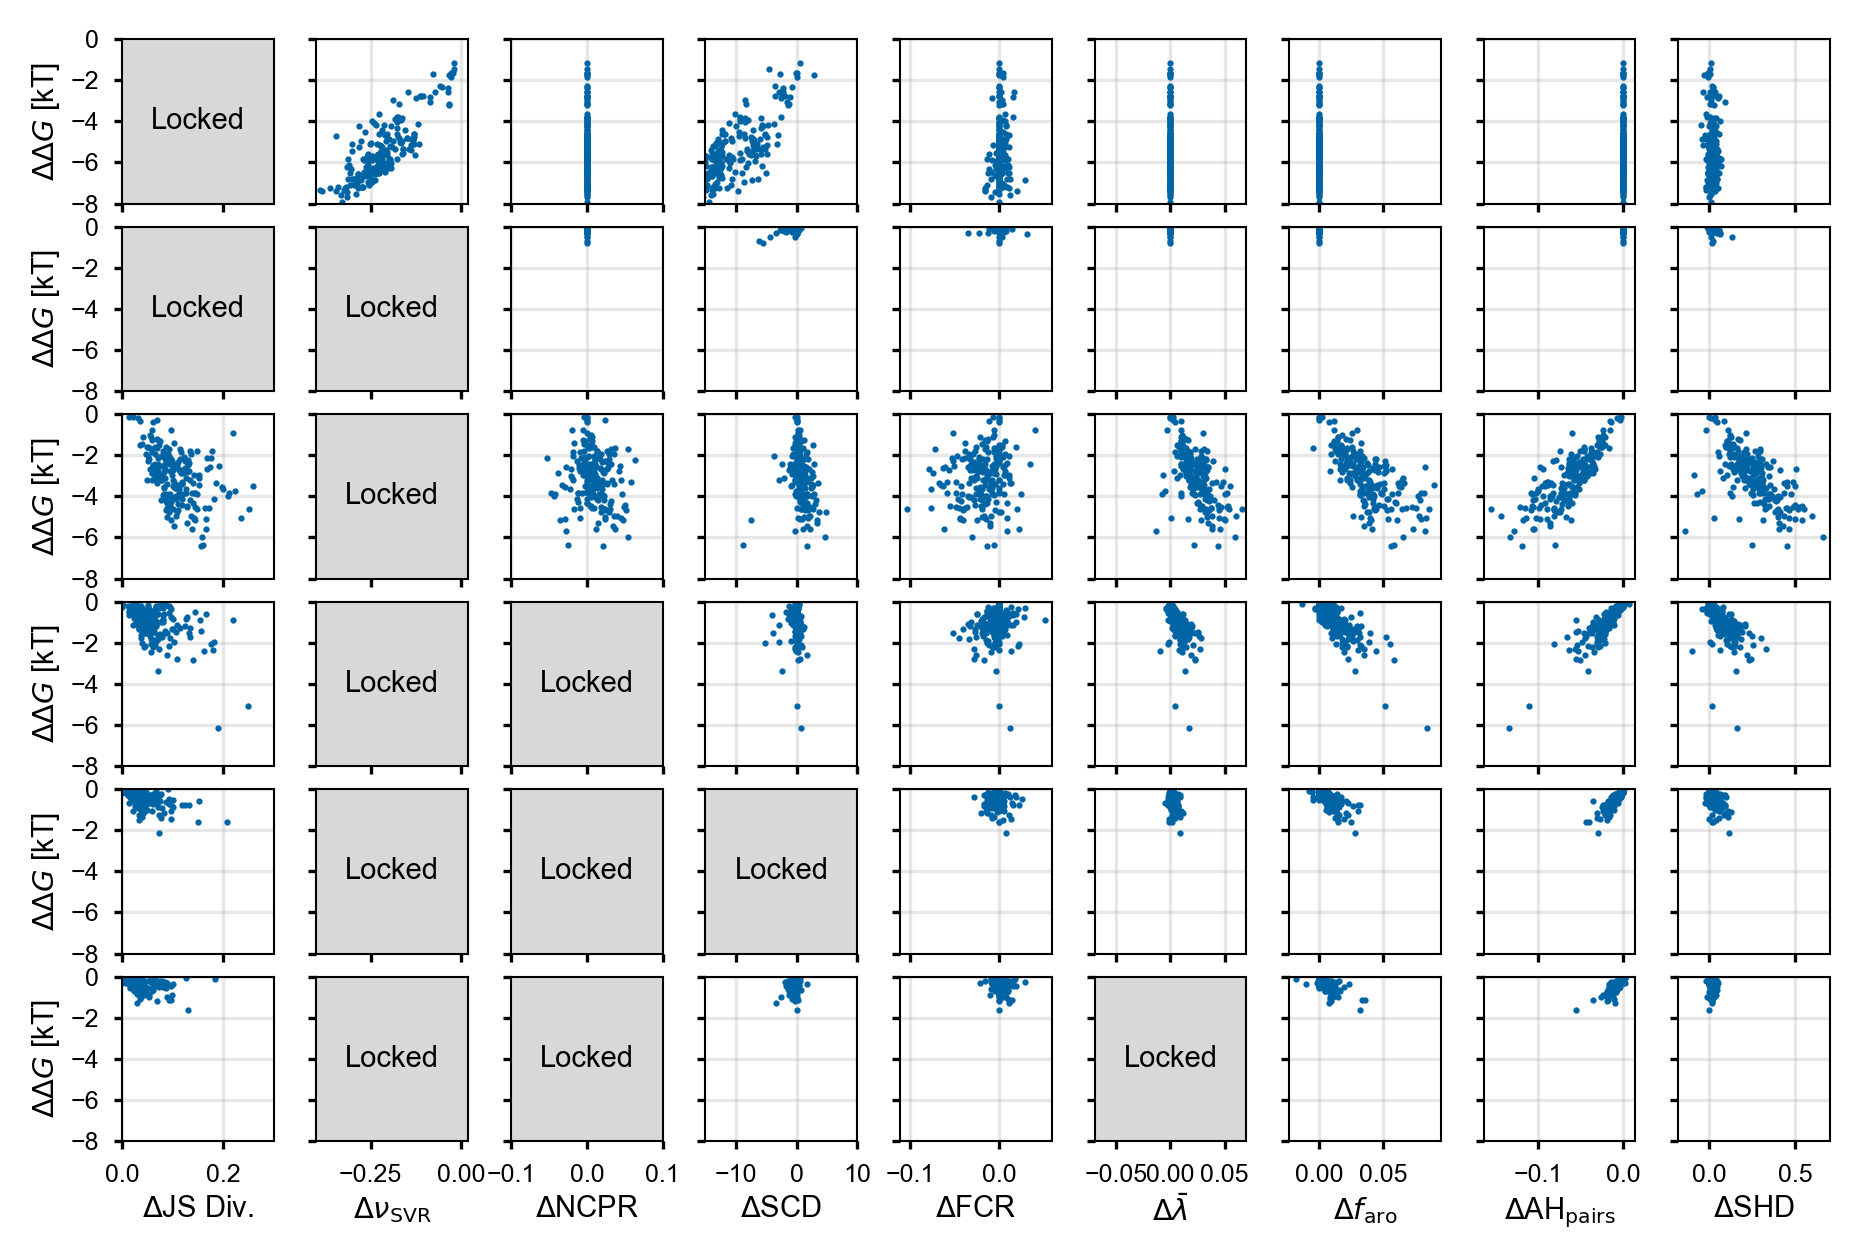

In [67]:
nruns = 200 # 100 # 170

constr_combinations = [
    [[], 1.],
    [['nu_svr'], 1.],
    [['nu_svr'], 0.5],
    [['nu_svr','ncpr'], 0.5],
    [['nu_svr','ncpr','scd'], 0.5],
    [['nu_svr','ncpr','mean_lambda'], 0.5],
]

features_plot = ['seqJS','nu_svr','ncpr','scd','fcr','mean_lambda','faro','ah_ij','shd']

fig, axes = plt.subplots(len(constr_combinations),len(features_plot),figsize=(6,4),#figsize=(11,9.5), 
                         sharex='col',sharey=True)

with open('run_mcs.sh','w') as f:
    for c_idx, (constraints, pswap) in enumerate(constr_combinations):
        while True:
            random.shuffle(constraints)
            ##
            features_extended = features + ['seqid', 'seqJS']
            dir_mc_base = 'data_revision/mc_runs'
            
            if len(constraints) == 0:
                str_constr = 'none'
            else:
                str_constr = "_".join(constraints)
            
            dir_mc = f'{dir_mc_base}/constr_{str_constr}/pswap{pswap:.2f}'
            # print(dir_mc)
            ##
            if os.path.isdir(dir_mc):
                break
        
        aminoacids = "ACDEFGHIKLMNPQRSTVWY"
        res_runs = []

        for idx in range(nruns):
            with open(f'{dir_mc}/run_{idx}.pkl','rb') as f:
                res = pickle.load(f)
                res_runs.append(res)

        for jdx, feat in enumerate(features_plot):
            ax = axes[c_idx, jdx] # axes[jdx, c_idx]  
            if (feat in constraints) or (feat=='seqJS' and pswap==1.):
                ax.set(ylim=[-8,0])
                ax.text(np.mean(dlimits_mc[feat]),-4,'Locked',fontsize=7,
                        horizontalalignment='center',
                       verticalalignment='center')
                ax.fill_between([-100,100],[-100,-100],[100,100],color='gray',alpha=0.3)
                ax.grid(False)
            else:
                c = colors[0]

                xdif = np.zeros((nruns))
                ydif = np.zeros((nruns))
                for idx in range(nruns):
                    
                    res = res_runs[idx]
                    xdif[idx] = res[feat][-1] - res[feat][0]
                    ydif[idx] = res['dG'][-1] - res['dG'][0]
                    
                ax.plot(xdif, ydif,'.',c=c,lw=0.5,markersize=2)

                if feat in limits_mc:
                    ax.set(xlim=dlimits_mc[feat])
                ax.set_yticks(np.arange(-8,0.1,2))

for c_idx, _ in enumerate(constr_combinations):
    axes[c_idx,0].set_ylabel(f'$\Delta${targets_clean["dG"]}',fontsize=7)
for jdx, feat in enumerate(features_plot):
    axes[-1,jdx].set_xlabel(f'$\Delta${features_clean[feat]}',fontsize=7)
fig.tight_layout(h_pad=0,w_pad=0,pad=0)
# fig.savefig(f'figures_revision/figS_mcs.pdf')

# Fig. S12 Nu dense vs. dilute

110
0 37
37
37 74
37
74 111
36


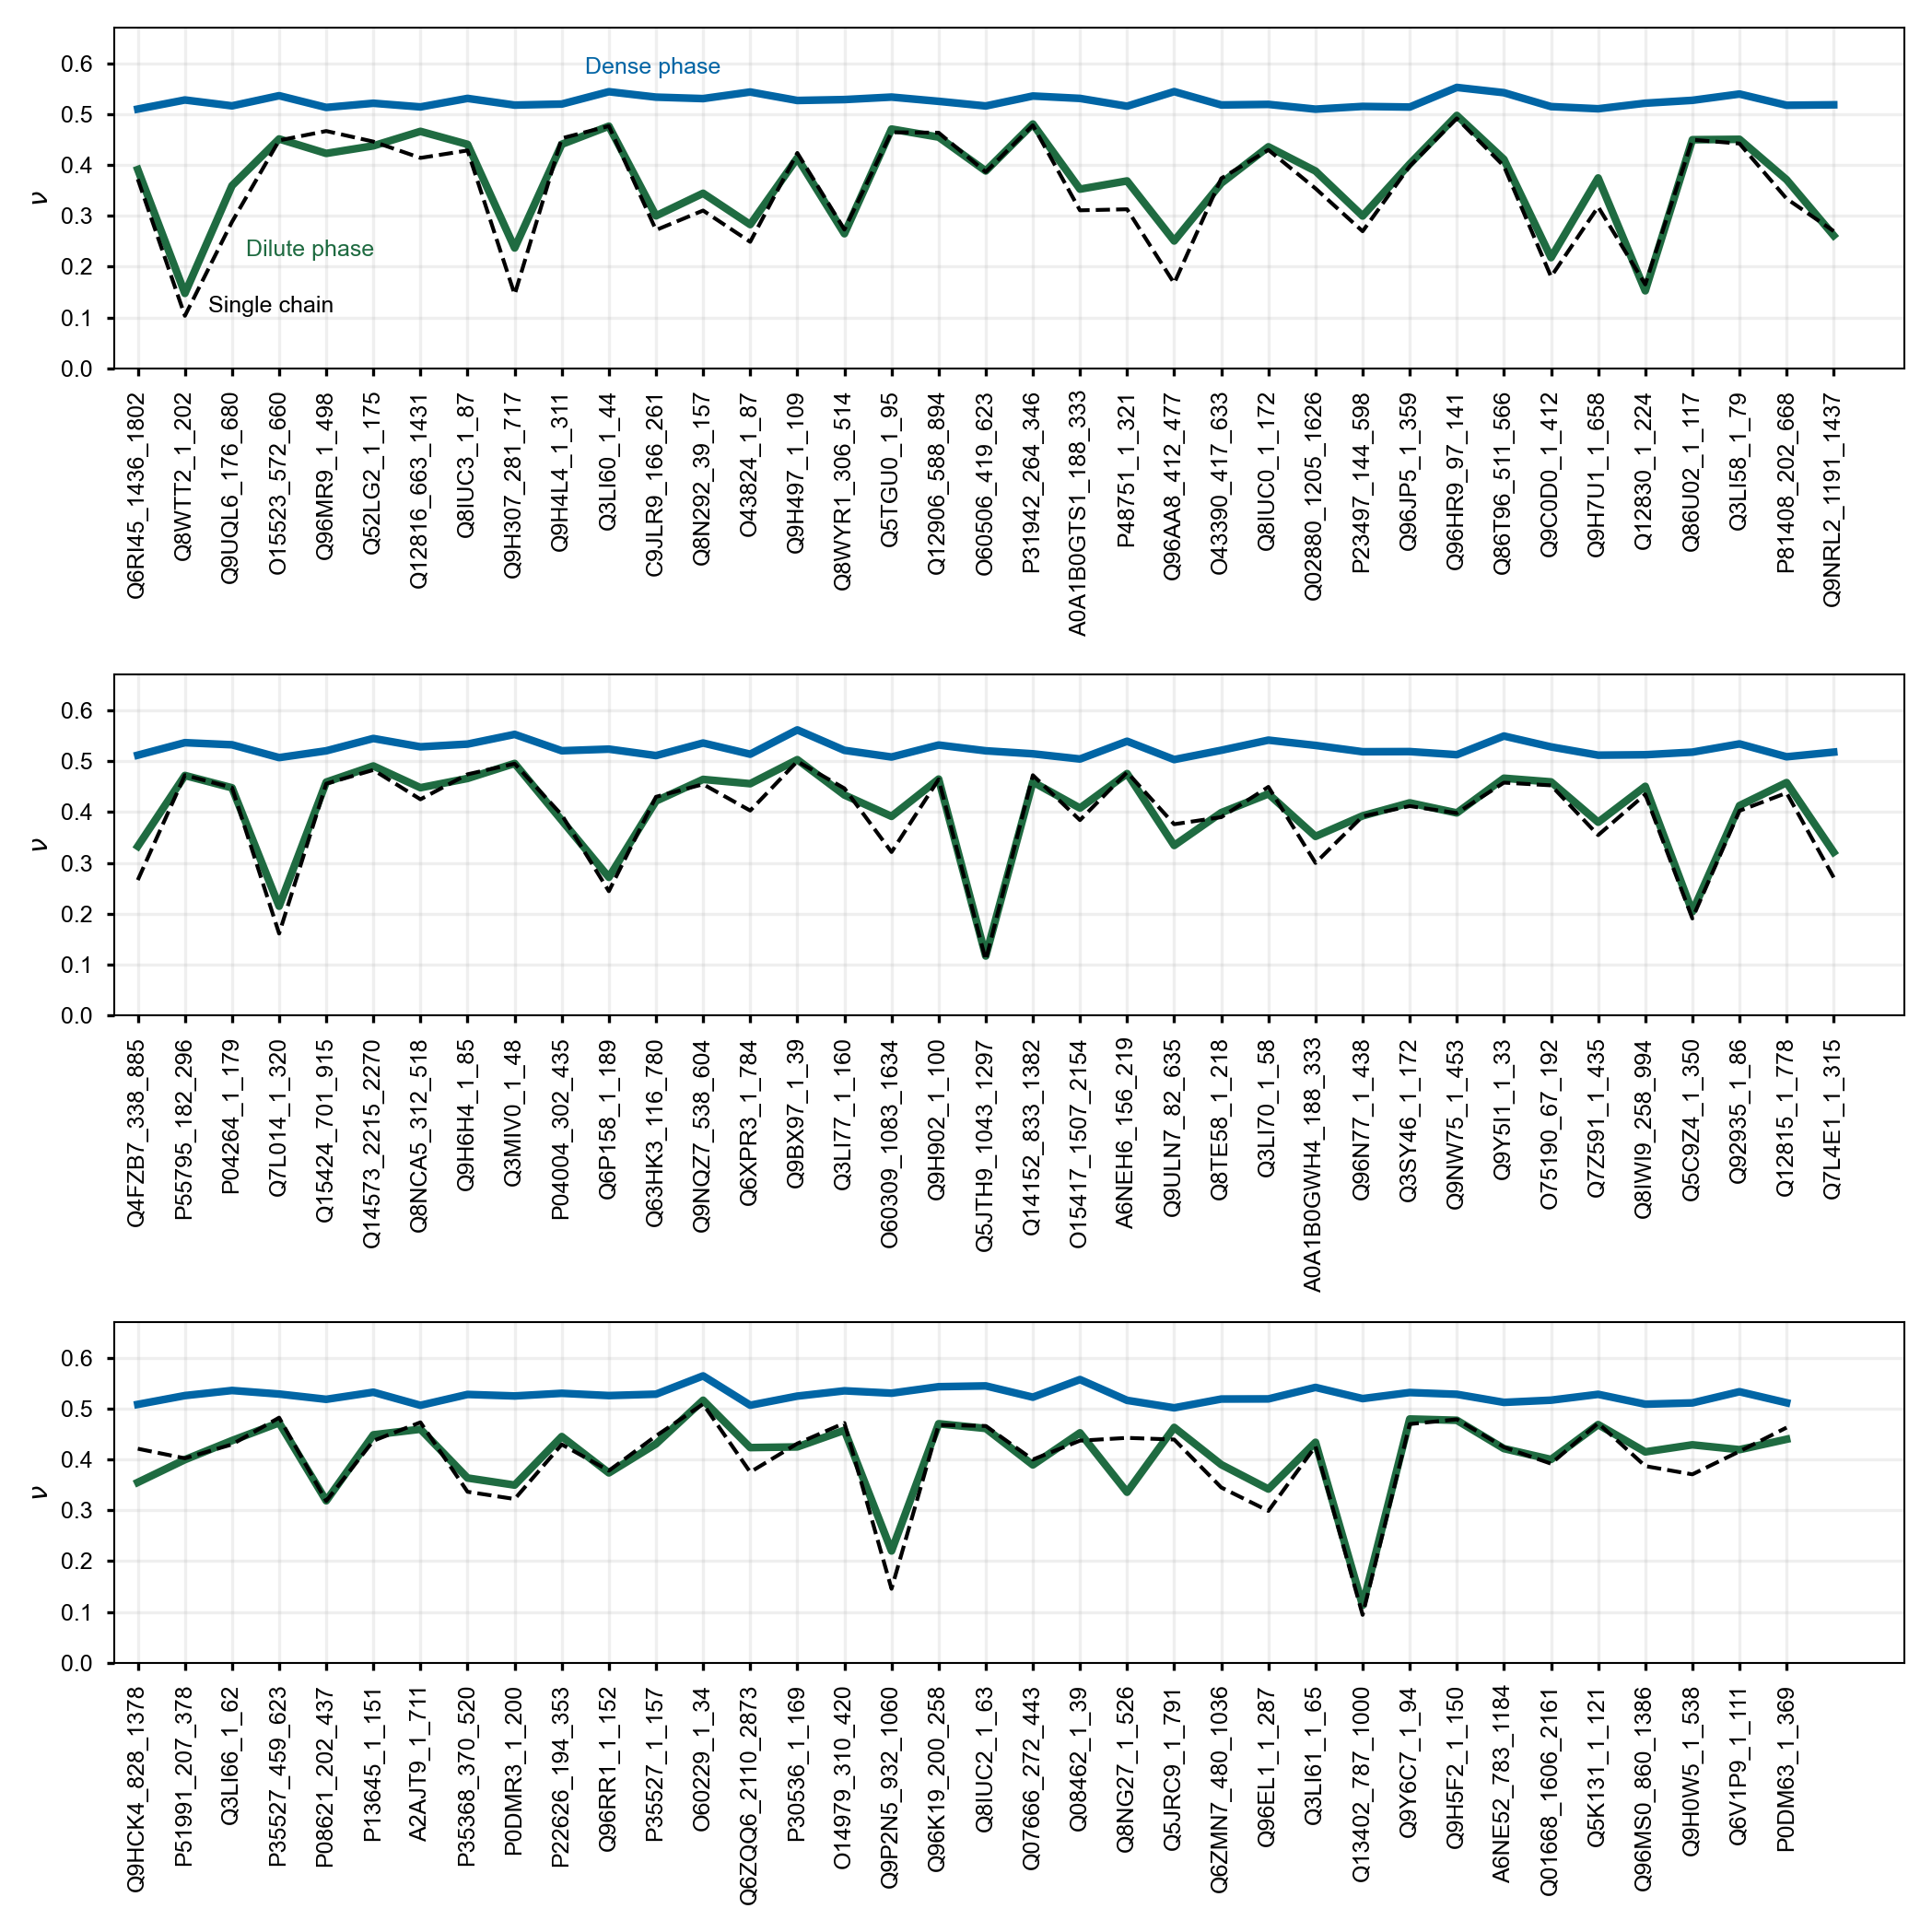

In [52]:
df_nu = pd.read_csv('data/df_nu.csv',index_col='seq_name')

fig, ax = plt.subplots(3,1,figsize=(col2x,col2x))

nseq = len(df_nu)
print(nseq)
for idx in range(3):
    axij = ax[idx]
    third = 37
    x0 = int(idx*third)#+1 # 141/3
    x1 = x0+int(third)
    print(x0,x1)
    
    xs = np.arange(len(df_nu))[x0:x1]
    print(len(xs))
    
    axij.plot(xs,df_nu['nu_dil'][x0:x1],label='dilute phase',color=colors[2],lw=2)#fcolor(0.))
    axij.plot(xs,df_nu['nu_den'][x0:x1],label='dense phase',color=colors[0],lw=2)#fcolor(0.5))
    # axij.plot(xs,nus_single_list[x0:x1],label='single chain sim',c='black',ls='dashed')
    axij.plot(xs,df_nu['nu_single'][x0:x1],label='single chain sim',c='black',ls='dashed')
    
    axij.set(xlim=(x0-0.5,x1+0.5))
    axij.set(ylim=(0,0.67))
    axij.set_xticks(xs)
    axij.set_xticklabels(df_nu.index[x0:x1],rotation=90,fontsize=6)
    axij.grid(alpha=0.2)
    axij.set_yticks([0.0,0.1,0.2,0.3,0.4,0.5,0.6])
    axij.set(ylabel=r'$\nu$')
    # ax.set_title(f'Scaling exponent for slab sims with dG < {dGmin}')

    # fig.savefig(f'figures/scaling_exp_dG_lt_{dGmin}.pdf')
ax[0].text(1.5,0.11,'Single chain',c='black',fontsize=6)
ax[0].text(2.3,0.22,'Dilute phase',c=colors[2],fontsize=6)
ax[0].text(9.5,0.58,'Dense phase',c=colors[0],fontsize=6)
fig.tight_layout()
# fig.savefig('figures/nu_per_phase.pdf')

# Predict single value

In [ ]:
model = models['idrome90']['mlp']['dG']

# FUS LCD
seq = '''MASNDYTQQATQSYGAYPTQPGQGYSQQSSQPYGQQSYSGYSQSTDTSGYGQSSYS
SYGQSQNTGYGTQSTPQGYGSTGGYGSSQSSQSSYGQQSSYPGYGQQPAPSSTSGSYGSSSQS
SSYGQPQSGSYSQQPSYGGQQQSYGQQQSYNPPQGYGQQNQYNS'''.replace('\n','')

X = X_from_seq(seq,features,residues=residues,charge_termini=True,nu_file=nu_file)
ys = model.predict(X)#,models)
print(np.mean(ys))